## Bibliotecas e Pacotes

In [1]:
#@title Configurações Exibição

import skimage
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches
import io
import time
from PIL import Image
from skimage.draw import polygon
from shapely import geometry
import math
import pickle
import sys
from shapely.geometry import Point, Polygon, LineString, CAP_STYLE
from shapely.affinity import translate, rotate, scale
from shapely.plotting import plot_polygon, plot_points
#from shapely.geometry import CAP_STYLE
import shapely
import matplotlib.colors as mcolors
from google.colab import drive


In [2]:
#@title GeneralUtils

class GeneralUtils():
  @staticmethod
  def pathG2path(path):
    new_path = Path()
    if path is not None:
      for node in path:
        new_path.add_point(shapely.Point(node.get_pos()))
      return new_path

  @staticmethod
  def pathO2path(path):
    new_path = Path()
    if path is not None:
      for node in path:
        new_path.add_point(shapely.Point(node))
      return new_path

  @staticmethod
  def is_none(v):
    try:
      if v:
        return True
      return True
    except:
      return False

  @staticmethod
  def calculate_metrics_statistics(metrics_array):
    """
    Calcula a média e o desvio padrão para cada métrica em um array de dicionários.

    Args:
    - metrics_array (list of dict): Lista de dicionários onde cada dicionário contém métricas.

    Returns:
    - means (dict): Dicionário com a média de cada métrica.
    - std_devs (dict): Dicionário com o desvio padrão de cada métrica.
    """
    if not metrics_array:
        raise ValueError("O array de métricas está vazio.")

    # Obtém os nomes das métricas a partir do primeiro dicionário
    metrics_names = list(metrics_array[0].get_all_metrics().keys())

    # Inicializa dicionários para armazenar médias e desvios padrão
    means = {}
    std_devs = {}

    # Organiza valores por métrica
    metrics_values = {metric: [] for metric in metrics_names}
    #print(metrics_values)
    for metric_dict in metrics_array:
        for metric, value in metric_dict.get_all_metrics().items():
            if metric in metrics_values:
                metrics_values[metric].append(value)

    # Calcula média e desvio padrão para cada métrica
    for metric, values in metrics_values.items():
        if values:
            means[metric] = np.mean(values)
            std_devs[metric] = np.std(values)
        else:
            means[metric] = None
            std_devs[metric] = None

    return means, std_devs




In [3]:
#@title SCARA class
class SCARA:
    def __init__(self, links_len=(35,30), origin=(0,0), initial_ang=(0,0), tool_diameter=4):
      #-10,40
      self.links_len = links_len
      self.initial_ang = initial_ang
      self.origin = origin
      self.tool_diameter = tool_diameter

      # initial state
      self.ox = self.origin[0]
      self.oy = self.origin[1]
      l1 = (self.links_len[0]+self.ox,self.oy)
      l2 = (self.links_len[0]+self.links_len[1]+self.ox,self.oy)
      lk1 = LineString([self.origin,l1])
      lk2 = LineString([l1,l2])
      self.links = [lk1,lk2]
      self.previous_ang = initial_ang
      #self.move(self.initial_ang)

      # lk1.xy endpoint:
      # xy[1][0] = x
      # xy[1][1] = y
      self.inner_radius = self.links_len[0]-np.cos(60*np.pi/180)*self.links_len[1]
      self.outter_radius = sum(self.links_len)
      #print("inner_radius=",self.inner_radius)
      #print("outter_radius=",self.outter_radius)
      self.envelope = Point(self.origin).buffer(self.outter_radius) - Point(self.origin).buffer(self.inner_radius)
      self.envelope = shapely.difference(Point(self.origin).buffer(self.outter_radius),Point(self.origin).buffer(self.inner_radius))
      self.envelope = Point(self.origin).buffer(self.outter_radius).difference(Point(self.origin).buffer(self.inner_radius))
      # self.envelope = Polygon(Point(self.origin).buffer(self.outter_radius), holes=[Point(self.origin).buffer(self.inner_radius)])
      # donut = Point(0, 0).buffer(2.0).difference(Point(0, 0).buffer(1.0))

    def valid_points(self, points=[]):
      if not isinstance(points,list):
        points = list(points)
      return [self.envelope.contains(Point(p)) for p in points]

    def inverse_kinematics(self,path):
          L1,L2 = self.links_len

          x = np.array([node.x for node in path])
          y = np.array([node.y for node in path])

          cos_theta2 = (x**2+y**2-(L1**2+L2**2))/(2*L1*L2)
          sin_theta2 = np.sqrt(abs(1-cos_theta2**2))

          theta2 = np.arctan2(sin_theta2,cos_theta2)

          k1 = L1+L2*cos_theta2
          k2 = L2*sin_theta2
          theta1 = np.arctan2(y,x) - np.arctan2(k2,k1)

          return np.rad2deg((theta1,theta2))

tool_diameter = 8
grid_size = np.array([60,60])
dpi = 150
#links_len = (35,30)
links_len = (33,38)
origin = (0,0)
initial_ang = (0,0)
#initial_ang = (130,-104)
#robot = SCARA(links_len=links_len,origin=origin,initial_ang=initial_ang)
robot = SCARA(links_len = links_len,
              origin = origin,
              initial_ang = initial_ang,
              tool_diameter = tool_diameter)
envelope = robot.envelope


In [4]:
#@title package el
class VisualizationUtils:

    @staticmethod
    def plotar_quadrado(canto_superior_esquerdo, canto_inferior_direito, cor='blue'):
        x1, y1 = canto_superior_esquerdo
        x2, y2 = canto_inferior_direito

        x3, y3 = x2, y1
        x4, y4 = x1, y2

        plt.plot([x1, x3, x2, x4, x1], [y1, y3, y2, y4, y1], color=cor)

class Skeleton:

  def __init__(self, image_roi, limites_roi, cenario):
    self.limites_roi = limites_roi
    self.image_roi = image_roi
    self.skeleton = GeometryUtils.get_points_skeleton(self.image_roi, self.limites_roi)
    self.cenario = cenario

  def get_skeleton(self):
    return self.skeleton

  def encontrar_ponto_proximo(self, ponto):
    return GeometryUtils.get_ponto_esqueleto_mais_proximo(ponto, self.skeleton)



  def determinar_extremidade_otima(self, ponto_direcao_1, ponto_direcao_2):
    #return GeometryUtils.encontrar_ponto_alinhado(self.skeleton, ponto_direcao_1, ponto_direcao_2)
    return GeometryUtils.encontrar_ponto_alinhado(self.get_extremidades(), ponto_direcao_1, ponto_direcao_2)

  def _get_skeleton_without_colisions(self, ponto):
    skeleton_without_colisions = []
    for e in self.get_skeleton():
      if not PathfindingUtils.algoritmo_bresenham_2_canais(ponto, e, 1 - self.cenario):
        skeleton_without_colisions.append(e)
    return skeleton_without_colisions

  def determinar_extremidade_otima_sem_colisao(self, ponto_direcao_1, ponto_direcao_2):
    skeleton_without_colisions = self._get_skeleton_without_colisions(ponto_direcao_1)
    if len(skeleton_without_colisions) == 0:
      print('Não há ponto sem colisão')
      return self.determinar_extremidade_otima(self, ponto_direcao_1, ponto_direcao_2)
    return GeometryUtils.encontrar_ponto_alinhado(
        skeleton_without_colisions, ponto_direcao_1, ponto_direcao_2)


  def get_extremidades(self):
    extremidades_relativas = np.array(ImageUtils.get2neighbor(self.image_roi))
    extremidades_absolutas = GeometryUtils.converte_pontos_relativos_em_absoluto(extremidades_relativas, self.limites_roi)
    return extremidades_absolutas

  def _ordena_array_linear(myList, startingPoint):

    def findNearestIndex(thisPoint, listToSearch):
      nearestDistSquared = np.inf
      nearestIndex = None
      for i, point2 in enumerate(listToSearch):
          distsq = np.sum((thisPoint - point2) ** 2)
          if distsq < nearestDistSquared:
              nearestDistSquared = distsq
              nearestIndex = i
      return nearestIndex


    myList = np.array(myList)


    startingPoint = np.array(startingPoint)

    orderedList = [startingPoint]

    while myList.shape[0] > 0:
        # Encontrar o índice do ponto mais próximo
        nearestIndex = findNearestIndex(orderedList[-1], myList)
        # Adicionar o ponto mais próximo à lista ordenada e removê-lo da lista original
        orderedList.append(myList[nearestIndex])
        myList = np.delete(myList, nearestIndex, axis=0)


    orderedList = np.array(orderedList)
    indice_remover = np.where((orderedList == startingPoint).all(axis=1))
    orderedList = np.delete(orderedList, indice_remover, axis=0)

    return orderedList

class Skeleton_new:

  def __init__(self, image_roi, limites_roi, cenario, ponto_inicial, ponto_final):
    self.limites_roi = limites_roi
    self.image_roi = image_roi
    self.skeleton = GeometryUtils.get_points_skeleton(self.image_roi, self.limites_roi)
    self.cenario = cenario
    self.ponto_inicial = ponto_inicial
    self.ponto_final = ponto_final

  def get_skeleton(self):
    extremidade_mais_prox_ponto_final = self._extremidade_mais_proxima_do_ponto_final()
    self.skeleton = self._ordena_array_linear(self.skeleton, extremidade_mais_prox_ponto_final)
    return self.skeleton

  def encontrar_ponto_proximo(self, ponto):
    esqueleto = self.get_skeleton()
    # Converter o ponto para um array NumPy
    ponto = np.array(ponto)

    # Calcular a distância euclidiana entre o ponto e todos os pontos no esqueleto
    distancias = np.linalg.norm(esqueleto - ponto, axis=1)

    # Encontrar o índice do ponto mais próximo
    indice_proximo = np.argmin(distancias)

    # Retornar o ponto mais próximo
    return esqueleto[indice_proximo]

  # def encontrar_ponto_proximo(self, ponto):
  #   return GeometryUtils.get_ponto_esqueleto_mais_proximo(ponto, self.skeleton)

  def _get_segmento_esqueleto(self, ponto_1, ponto_2):
    # Verificar se ponto_1 e ponto_2 estão no esqueleto
    esqueleto = self.get_skeleton()
    if ponto_1 not in esqueleto.tolist() or ponto_2 not in esqueleto.tolist():
        raise ValueError("Ambos os pontos devem estar presentes no esqueleto.")

    # Encontrar os índices dos pontos no esqueleto
    indice_ponto_1 = np.where((esqueleto == ponto_1).all(axis=1))[0][0]
    indice_ponto_2 = np.where((esqueleto == ponto_2).all(axis=1))[0][0]

    # Se os índices não estiverem na ordem certa, inverter
    if indice_ponto_1 > indice_ponto_2:
        indice_ponto_1, indice_ponto_2 = indice_ponto_2, indice_ponto_1

    # Extrair o segmento
    segmento = esqueleto[indice_ponto_1:indice_ponto_2 + 1]

    return segmento

  def get_segmento_proximo(self, ponto):
    # Encontrar o ponto mais próximo no esqueleto
    ponto_proximo = self.encontrar_ponto_proximo(ponto)

    # Encontrar o segmento que contém o ponto mais próximo
    segmento = self._get_segmento_esqueleto(ponto, self._extremidade_mais_proxima_do_ponto_final())

    return segmento


  def _extremidade_mais_proxima_do_ponto_final(self):
    dist = np.inf
    for e in self.get_extremidades():
      d = GeometryUtils.distancia_entre_pontos(e, self.ponto_final)
      if d < dist:
        dist = d
        extremidade_mais_proxima = e
    return extremidade_mais_proxima

  def determinar_extremidade_otima(self, ponto_direcao_1, ponto_direcao_2):
    #return GeometryUtils.encontrar_ponto_alinhado(self.skeleton, ponto_direcao_1, ponto_direcao_2)
    return GeometryUtils.encontrar_ponto_alinhado(self.get_extremidades(), ponto_direcao_1, ponto_direcao_2)

  def _get_skeleton_without_colisions(self, ponto):
    skeleton_without_colisions = []
    for e in self.get_skeleton():
      if not PathfindingUtils.algoritmo_bresenham_2_canais(ponto, e, 1 - self.cenario):
        skeleton_without_colisions.append(e)
    return skeleton_without_colisions

  def determinar_extremidade_otima_sem_colisao(self, ponto_direcao_1, ponto_direcao_2):
    skeleton_without_colisions = self._get_skeleton_without_colisions(ponto_direcao_1)
    if len(skeleton_without_colisions) == 0:
      print('Não há ponto sem colisão')
      return self.determinar_extremidade_otima(self, ponto_direcao_1, ponto_direcao_2)
    return GeometryUtils.encontrar_ponto_alinhado(
        skeleton_without_colisions, ponto_direcao_1, ponto_direcao_2)


  def get_extremidades(self):
    extremidades_relativas = np.array(ImageUtils.get2neighbor(self.image_roi))
    extremidades_absolutas = GeometryUtils.converte_pontos_relativos_em_absoluto(extremidades_relativas, self.limites_roi)
    return extremidades_absolutas

  def _ordena_array_linear(self, myList, startingPoint):

    def findNearestIndex(thisPoint, listToSearch):
      nearestDistSquared = np.inf
      nearestIndex = None
      for i, point2 in enumerate(listToSearch):
          distsq = np.sum((thisPoint - point2) ** 2)
          if distsq < nearestDistSquared:
              nearestDistSquared = distsq
              nearestIndex = i
      return nearestIndex


    myList = np.array(myList)


    startingPoint = np.array(startingPoint)

    orderedList = [startingPoint]

    while myList.shape[0] > 0:
        # Encontrar o índice do ponto mais próximo
        nearestIndex = findNearestIndex(orderedList[-1], myList)
        # Adicionar o ponto mais próximo à lista ordenada e removê-lo da lista original
        orderedList.append(myList[nearestIndex])
        myList = np.delete(myList, nearestIndex, axis=0)


    orderedList = np.array(orderedList)
    indice_remover = np.where((orderedList == startingPoint).all(axis=1))
    orderedList = np.delete(orderedList, indice_remover, axis=0)

    return orderedList


class GeometryUtils:

    @staticmethod
    def calcular_angulo_entre_vetores(A, O, C):
        OA = np.array([A[0] - O[0], A[1] - O[1]])
        OC = np.array([C[0] - O[0], C[1] - O[1]])

        produto_escalar = np.dot(OA, OC)
        norma_OA = np.linalg.norm(OA)
        norma_OC = np.linalg.norm(OC)

        cos_angulo = produto_escalar / (norma_OA * norma_OC)

        # Clamping to handle numerical issues
        cos_angulo = np.clip(cos_angulo, -1.0, 1.0)

        angulo_radianos = np.arccos(cos_angulo)
        return np.degrees(angulo_radianos)


    @staticmethod
    def encontrar_ponto_alinhado(extremidades_absolutas, ponto_direcao_1, ponto_direcao_2):

      menor_angulo = np.inf

      novo_ponto_direcao_2 = ponto_direcao_2

      for ea in extremidades_absolutas:
        if np.array_equal(ea, ponto_direcao_1) or np.array_equal(ea, ponto_direcao_2):
          continue
        ang = GeometryUtils.calcular_angulo_entre_vetores(ponto_direcao_1, ponto_direcao_2, ea)

        if 180 - ang < menor_angulo:
          menor_angulo = 180 - ang
          novo_ponto_direcao_2 = ea
      #print('novo_ponto_direcao_2', novo_ponto_direcao_2)
      return tuple(novo_ponto_direcao_2)

    @staticmethod
    def melhor_angulo_entre_extremidades_sem_colisao(pontos_esqueleto_roi_absoluto, extremidade_melhor_angulo, ponto_direcao_2, cenario):

      esqueleto_ordenado = PathfindingUtils.ordena_array_linear(pontos_esqueleto_roi_absoluto, extremidade_melhor_angulo)

      for eo in esqueleto_ordenado:
        if not PathfindingUtils.algoritmo_bresenham(ponto_direcao_2, eo, cenario):
          break
      extremidade_melhor_angulo_sem_colisao = eo

      return extremidade_melhor_angulo_sem_colisao

    @staticmethod
    def converte_pontos_relativos_em_absoluto(white_points, limites_roi):
      return white_points + (limites_roi[0][0], limites_roi[1][1])

    @staticmethod
    def get_points_skeleton(image_skeleton, limites_roi):#, limites_roi=((0, tamanho_cenario[0]), (tamanho_cenario[1], 0))):

      white_indices = np.where(image_skeleton == True)

      if white_indices[0].size == 0:
        return np.array([])

      white_points = np.column_stack((white_indices[1], white_indices[0]))

      pontos_esqueleto_roi_absoluto = GeometryUtils.converte_pontos_relativos_em_absoluto(white_points, limites_roi)
      #white_points = white_points_roi + (limites_roi[0][0], limites_roi[1][1])

      return pontos_esqueleto_roi_absoluto# white_points

    @staticmethod
    def get_roi(limites_roi, cenario):
      x_min = limites_roi[0][0]
      x_max = limites_roi[1][0]
      y_min = limites_roi[1][1]
      y_max = limites_roi[0][1]

      roi = cenario[y_min:y_max, x_min:x_max]

      return roi

    @staticmethod
    def calcular_intersecao_com_limite(ponto_A, limites, ponto_B):
      # Descompacta os limites do quadrado
      x_min, y_max = limites[0]  # Superior esquerdo
      x_max, y_min = limites[1]  # Inferior direito

      # Calcula os coeficientes da equação da reta que passa por A e B
      delta_x = ponto_B[0] - ponto_A[0]
      delta_y = ponto_B[1] - ponto_A[1]

      # Inicializa a lista de interseções
      intersecoes = []

      # Interseção com o lado esquerdo (x = x_min)
      if delta_x != 0:  # Evita divisão por zero
          t = (x_min - ponto_A[0]) / delta_x
          y_intersecao = ponto_A[1] + t * delta_y
          if y_min <= y_intersecao <= y_max:
              intersecoes.append((x_min, y_intersecao))

      # Interseção com o lado direito (x = x_max)
      if delta_x != 0:
          t = (x_max - ponto_A[0]) / delta_x
          y_intersecao = ponto_A[1] + t * delta_y
          if y_min <= y_intersecao <= y_max:
              intersecoes.append((x_max, y_intersecao))

      # Interseção com o lado inferior (y = y_min)
      if delta_y != 0:  # Evita divisão por zero
          t = (y_min - ponto_A[1]) / delta_y
          x_intersecao = ponto_A[0] + t * delta_x
          if x_min <= x_intersecao <= x_max:
              intersecoes.append((x_intersecao, y_min))

      # Interseção com o lado superior (y = y_max)
      if delta_y != 0:
          t = (y_max - ponto_A[1]) / delta_y
          x_intersecao = ponto_A[0] + t * delta_x
          if x_min <= x_intersecao <= x_max:
              intersecoes.append((x_intersecao, y_max))

      # Verifica a interseção mais próxima na direção do ponto B
      if intersecoes:
          # Calcula a distância ao ponto B para cada interseção e escolhe a menor
          intersecoes.sort(key=lambda ponto: np.linalg.norm(np.array(ponto) - np.array(ponto_B)))
          return intersecoes[0]
      else:
          return None  # Caso não haja interseção (improvável no caso de um quadrado)

    @staticmethod
    def ponto_interseccao_roi(limites_roi, ponto_inicio_roi, ponto_final):
      try:
        angulo_reta = math.atan(GeometryUtils.inclinacao_da_reta(ponto_inicio_roi, ponto_final))
      except ZeroDivisionError:
        # Se a inclinação for infinita, o ângulo deve ser pi/2 (90 graus)
        angulo_reta = math.pi / 2

      K = (limites_roi[0][0], limites_roi[1][1])
      L = limites_roi[0]
      M = (limites_roi[1][0], limites_roi[0][1])
      N = limites_roi[1]

      if angulo_reta <= 0.78: # 45 graus em radianos
        ponto_inter = GeometryUtils.ponto_de_intersecao_reta_vertical(ponto_inicio_roi, ponto_final, M[0]) # p_MN_PQ
      else:
        ponto_inter = GeometryUtils.ponto_de_intersecao_reta_horizontal(ponto_inicio_roi, ponto_final, L[1]) # p_LM_PQ

      return ponto_inter

    @staticmethod
    def calculate_total_distance(points):
        points = np.array(points)
        distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
        return np.sum(distances)

    @staticmethod
    def distancia_entre_pontos(ponto1, ponto2):
        x1, y1 = ponto1
        x2, y2 = ponto2
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    @staticmethod
    def inclinacao_da_reta(ponto1, ponto2):
        x1, y1 = ponto1
        x2, y2 = ponto2
        return (y2 - y1) / (x2 - x1)

    @staticmethod
    def equacao_da_reta(ponto1, ponto2):
        x1, y1 = ponto1
        x2, y2 = ponto2
        if x1 == x2:
            return f"x = {x1}"
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        return (m, b)

    @staticmethod
    def ponto_de_intersecao_reta_vertical(ponto1, ponto2, x_vertical):
        m, b = GeometryUtils.equacao_da_reta(ponto1, ponto2)
        y_intersecao = m * x_vertical + b
        return (x_vertical, y_intersecao)

    @staticmethod
    def ponto_de_intersecao_reta_horizontal(ponto1, ponto2, y_horizontal):
        m, b = GeometryUtils.equacao_da_reta(ponto1, ponto2)
        x_intersecao = (y_horizontal - b) / m
        return (x_intersecao, y_horizontal)

    @staticmethod
    def angulo_entre_3_pontos(A, O, C):
        OA = [A[0] - O[0], A[1] - O[1]]
        OC = [C[0] - O[0], C[1] - O[1]]
        produto_escalar = OA[0] * OC[0] + OA[1] * OC[1]
        norma_OA = np.linalg.norm(OA)
        norma_OC = np.linalg.norm(OC)
        cos_angulo = produto_escalar / (norma_OA * norma_OC)
        angulo_radianos = np.arccos(cos_angulo)
        return np.degrees(angulo_radianos)

    @staticmethod
    def calcula_left_top_right_bottom_roi(centro_roi, tamanho_roi):
      w, h = tamanho_roi[1], tamanho_roi[0]
      x, y = centro_roi[0], centro_roi[1]
      left = x - (w / 2)
      top = y + (h / 2)
      right = x + (w / 2)
      bottom = y - (h / 2)
      return (round(left), round(top)), (round(right), round(bottom))

class ImageUtils:

    @staticmethod
    def binarizacao_imagem_skimage(imagem, threshold=0.99):
        unique_values = np.unique(imagem)
        if len(unique_values) == 2 and (0 in unique_values) and (1 in unique_values or 255 in unique_values):
            return imagem
        image_gray = skimage.color.rgb2gray(imagem[..., :3])

        return (image_gray > threshold).astype(float)

    @staticmethod
    def binarizacao_imagem_cv(imagem, threshold=254):
        unique_values = np.unique(imagem)
        if len(unique_values) == 2 and (0 in unique_values) and (255 in unique_values):
            return imagem
        _, thresh = cv.threshold(imagem, threshold, 255, cv.THRESH_BINARY)
        return thresh

    @staticmethod
    def esqueletiza_imagem_skimage(imagem, metodo='skeletonize', threshold_skimage=0.99):
        img_binaria = ImageUtils.binarizacao_imagem_skimage(imagem, threshold_skimage)

        if metodo == 'skeletonize':
            return skimage.morphology.skeletonize(img_binaria)
        if metodo == 'thin':
            return skimage.morphology.thin(img_binaria)

    @staticmethod
    def get2neighbor(image):
        def contar_vizinhos(image, x, y):
            vizinhos = [(x-1, y-1), (x-1, y), (x-1, y+1), (x, y-1), (x, y+1), (x+1, y-1), (x+1, y), (x+1, y+1)]
            return sum(1 for (i, j) in vizinhos if 0 <= i < image.shape[0] and 0 <= j < image.shape[1] and image[i, j] > 0)
        coordenadas_esqueleto = np.column_stack(np.where(image > 0))
        return [(y, x) for (x, y) in coordenadas_esqueleto if contar_vizinhos(image, x, y) == 1]

    @staticmethod
    def find_skeleton_coordinates(image_skeleton):
        rows, cols = np.nonzero(image_skeleton)
        skel_coords = [(c, r) for r, c in zip(rows, cols) if np.sum(image_skeleton[r-1:r+2, c-1:c+2].ravel() != 0) == 2]
        return np.array(skel_coords)

    @staticmethod
    def is_any_neighbor_black(image, x, y):
        aux = x
        x = y
        y = aux
        rows, cols = image.shape
        neighbors = [
            (x-1, y-1), (x-1, y), (x-1, y+1),
            (x, y-1),           (x, y+1),
            (x+1, y-1), (x+1, y), (x+1, y+1)
        ]
        for nx, ny in neighbors:
            if 0 <= nx < rows and 0 <= ny < cols:
                if image[nx, ny] == 0:
                    return True
        return False

class ScenarioUtils:

    @staticmethod
    def cria_imagem(lista_obstaculos, figsize=(5, 5), tamanho_cenario=(60, 60), dpi=200):
        fig, ax = plt.subplots(figsize=figsize)
        for poligono in lista_obstaculos:
            poly = matplotlib.patches.Polygon(poligono, closed=True, facecolor='black', edgecolor='black')
            ax.add_patch(poly)
        ax.set_xlim(0, tamanho_cenario[0])
        ax.set_ylim(0, tamanho_cenario[1])
        plt.axis('off')
        buffer = io.BytesIO()
        plt.gca().invert_yaxis()
        plt.savefig(buffer, format='png', bbox_inches='tight', pad_inches=0.0, dpi=dpi)
        buffer.seek(0)
        return np.array(Image.open(io.BytesIO(buffer.getvalue())))

    @staticmethod
    def add_margem_cenario(cenario, margem_seguranca):
        return [obs.buffer(margem_seguranca) if isinstance(obs, geometry.Polygon) else obs for obs in cenario]

    @staticmethod
    def wkt_to_obstaculos(wkt_geometries):
        obstaculos = []
        def wkt_to_coordinates(wkt):
            coordinates = wkt.replace("POLYGON ((", "").replace("))", "").split(", ")
            return [tuple(map(float, coord.split(" "))) for coord in coordinates]
        for wkt_geometry in wkt_geometries:
            if isinstance(wkt_geometry, geometry.Polygon):
                coordinates = list(wkt_geometry.exterior.coords)
            else:
                coordinates = wkt_to_coordinates(wkt_geometry)
            obstaculos.append(coordinates)
        return obstaculos

    @staticmethod
    def show_iteration2(cenario, ponto_inicial, ponto_final, historico_limites_roi=None, historico_esqueletos=None, pontos=[], exibir_contorno_roi=True):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cenario, cmap='gray')
        plt.gca().invert_yaxis()
        plt.scatter(ponto_inicial[0], ponto_inicial[1], color='green', s=140)
        plt.scatter(ponto_final[0], ponto_final[1], color='red', s=140)

        if exibir_contorno_roi:
            for hr in historico_limites_roi:
                VisualizationUtils.plotar_quadrado(hr[0], hr[1], cor='yellow')
            VisualizationUtils.plotar_quadrado(historico_limites_roi[-1][0], historico_limites_roi[-1][1], cor='orange')

        if historico_esqueletos is not None:
            for he in historico_esqueletos:
                plt.scatter(he[:, 0], he[:, 1], color='blue', s=10)


        if pontos:
          for ponto in pontos:
            plt.scatter(ponto[0], ponto[1], color='black', s=10)
        # if mostra_esqueleto:
        #     if esqueletos:
        #         for esq in esqueletos:
        #             plt.scatter(esq[:, 0], esq[:, 1], color=cor_esqueleto, s=largura_esqueleto)
        #         plt.scatter(esq[:, 0], esq[:, 1], color=cor_ultimo_esqueleto, s=largura_esqueleto)
        #     if mostra_extremidades and isinstance(extremidades_absolutas, np.ndarray):
        #         extx = [p[0] for p in extremidades_absolutas]
        #         exty = [p[1] for p in extremidades_absolutas]
        #         for ext in np.array(extremidades_absolutas):
        #             plt.scatter(extx, exty, color=cor_esqueleto_extremidades, s=tamanho_esqueleto_extremidades)

        # if mostra_pontos_direcao:
        #     plt.scatter(ponto_direcao_1[0], ponto_direcao_1[1], color=cor_ponto_direcao_1, s=tamanho_pontos_direcao)
        #     plt.scatter(ponto_direcao_2[0], ponto_direcao_2[1], color=cor_ponto_direcao_2, s=tamanho_pontos_direcao)

        # if mostra_caminho:
        #     x = [p[0] for p in pontos_caminho]
        #     y = [p[1] for p in pontos_caminho]
        #     plt.plot(x, y, color=cor_caminho)

        plt.subplot(1, 3, 2)
        plt.imshow(cenario, cmap='gray')
        if historico_esqueletos is not None:
          for he in historico_esqueletos:
            plt.scatter(he[:, 0], he[:, 1], color='blue', s=20)
        # if mostra_esqueleto:
        #     if esqueletos:
        #         for esq in esqueletos:
        #             plt.scatter(esq[:, 0], esq[:, 1], color=cor_esqueleto, s=largura_esqueleto_roi)
        #         plt.scatter(esq[:, 0], esq[:, 1], color=cor_ultimo_esqueleto, s=largura_esqueleto_roi)

        #     if mostra_extremidades and isinstance(extremidades_absolutas, np.ndarray):
        #         extx = [p[0] for p in extremidades_absolutas]
        #         exty = [p[1] for p in extremidades_absolutas]
        #         for ext in np.array(extremidades_absolutas):
        #             plt.scatter(extx, exty, color=cor_esqueleto_extremidades, s=tamanho_esqueleto_extremidades)

        # if mostra_pontos_direcao:
        #     plt.scatter(ponto_direcao_1[0], ponto_direcao_1[1], color=cor_ponto_direcao_1, s=tamanho_pontos_direcao)
        #     plt.scatter(ponto_direcao_2[0], ponto_direcao_2[1], color=cor_ponto_direcao_2, s=tamanho_pontos_direcao)

        # if mostra_caminho:
        #     x = [p[0] for p in pontos_caminho]
        #     y = [p[1] for p in pontos_caminho]
        #     plt.plot(x, y, color=cor_caminho)

        plt.scatter(ponto_inicial[0], ponto_inicial[1], color='green', s=140)
        plt.scatter(ponto_final[0], ponto_final[1], color='red', s=140)
        if pontos:
          for ponto in pontos:
            plt.scatter(ponto[0], ponto[1], color='black', s=10)

        plt.xlim(historico_limites_roi[-1][0][0], historico_limites_roi[-1][1][0])
        plt.ylim(historico_limites_roi[-1][0][1], historico_limites_roi[-1][1][1])
        plt.gca().invert_yaxis()

        #plt.show()

    @staticmethod
    def plot_scenario_subplot(cenario, ponto_inicial, ponto_final, historico_limites_roi=None,
                          historico_esqueletos=None, pontos=[], exibir_contorno_roi=True, ax=None):

      ax.imshow(cenario, cmap='gray')
      ax.invert_yaxis()
      ax.scatter(ponto_inicial[0], ponto_inicial[1], color='green', s=140)
      ax.scatter(ponto_final[0], ponto_final[1], color='red', s=140)

      if exibir_contorno_roi and historico_limites_roi:
          for hr in historico_limites_roi:
              VisualizationUtils.plotar_quadrado(hr[0], hr[1], cor='yellow')
          VisualizationUtils.plotar_quadrado(historico_limites_roi[-1][0], historico_limites_roi[-1][1], cor='orange')

      if historico_esqueletos is not None:
          for he in historico_esqueletos:
              ax.scatter(he[:, 0], he[:, 1], color='blue', s=10)

      if pontos:
          # Exibir cada ponto em uma cor diferente
          cor = ['#FF00FF', '#FF4500', '#800000', '#4B0082']
          for i, ponto in enumerate(pontos):
              ax.scatter(ponto[0], ponto[1], color=f'{cor[i]}', s=50)

    @staticmethod
    def show_iteration(cenario, ponto_inicial, ponto_final, historico_limites_roi=None, historico_esqueletos=None,
                      pontos=[], exibir_contorno_roi=True):
        """
        Mostra uma iteração do cenário com os pontos iniciais, finais e esqueleto.
        """
        plt.figure(figsize=(15, 5))

        # Subplot 1
        ax1 = plt.subplot(1, 3, 1)
        ScenarioUtils.plot_scenario_subplot(cenario, ponto_inicial, ponto_final, historico_limites_roi, historico_esqueletos,
                              pontos, exibir_contorno_roi, ax1)

        # Subplot 2
        ax2 = plt.subplot(1, 3, 2)
        ScenarioUtils.plot_scenario_subplot(cenario, ponto_inicial, ponto_final, historico_limites_roi, historico_esqueletos,
                              pontos, exibir_contorno_roi=False, ax=ax2)

        if historico_limites_roi:
            ax2.set_xlim(historico_limites_roi[-1][0][0], historico_limites_roi[-1][1][0])
            ax2.set_ylim(historico_limites_roi[-1][0][1], historico_limites_roi[-1][1][1])
            ax2.invert_yaxis()

        #plt.show()

    @staticmethod
    def exibe_iteracoes(cenario, limites_roi_all, esqueletos, pontos_caminho, ponto_direcao_1, ponto_direcao_2, extremidades_absolutas=False):
        plt.figure(figsize=tamanho_figura)
        plt.subplot(1, 3, 1)
        plt.imshow(cenario, cmap='gray')
        plt.gca().invert_yaxis()
        plt.scatter(ponto_inicial[0], ponto_inicial[1], color='green', s=140)
        plt.scatter(ponto_final[0], ponto_final[1], color='red', s=140)

        if mostra_contorno_roi:
            for lr in limites_roi_all:
                VisualizationUtils.plotar_quadrado(lr[0], lr[1], cor=cor_contorno_roi)
            VisualizationUtils.plotar_quadrado(limites_roi_all[-1][0], limites_roi_all[-1][1], cor='orange')

        if mostra_esqueleto:
            if esqueletos:
                for esq in esqueletos:
                    plt.scatter(esq[:, 0], esq[:, 1], color=cor_esqueleto, s=largura_esqueleto)
                plt.scatter(esq[:, 0], esq[:, 1], color=cor_ultimo_esqueleto, s=largura_esqueleto)
            if mostra_extremidades and isinstance(extremidades_absolutas, np.ndarray):
                extx = [p[0] for p in extremidades_absolutas]
                exty = [p[1] for p in extremidades_absolutas]
                for ext in np.array(extremidades_absolutas):
                    plt.scatter(extx, exty, color=cor_esqueleto_extremidades, s=tamanho_esqueleto_extremidades)

        if mostra_pontos_direcao:
            plt.scatter(ponto_direcao_1[0], ponto_direcao_1[1], color=cor_ponto_direcao_1, s=tamanho_pontos_direcao)
            plt.scatter(ponto_direcao_2[0], ponto_direcao_2[1], color=cor_ponto_direcao_2, s=tamanho_pontos_direcao)

        if mostra_caminho:
            x = [p[0] for p in pontos_caminho]
            y = [p[1] for p in pontos_caminho]
            plt.plot(x, y, color=cor_caminho)

        plt.subplot(1, 3, 2)
        plt.imshow(cenario, cmap='gray')

        if mostra_esqueleto:
            if esqueletos:
                for esq in esqueletos:
                    plt.scatter(esq[:, 0], esq[:, 1], color=cor_esqueleto, s=largura_esqueleto_roi)
                plt.scatter(esq[:, 0], esq[:, 1], color=cor_ultimo_esqueleto, s=largura_esqueleto_roi)

            if mostra_extremidades and isinstance(extremidades_absolutas, np.ndarray):
                extx = [p[0] for p in extremidades_absolutas]
                exty = [p[1] for p in extremidades_absolutas]
                for ext in np.array(extremidades_absolutas):
                    plt.scatter(extx, exty, color=cor_esqueleto_extremidades, s=tamanho_esqueleto_extremidades)

        if mostra_pontos_direcao:
            plt.scatter(ponto_direcao_1[0], ponto_direcao_1[1], color=cor_ponto_direcao_1, s=tamanho_pontos_direcao)
            plt.scatter(ponto_direcao_2[0], ponto_direcao_2[1], color=cor_ponto_direcao_2, s=tamanho_pontos_direcao)

        if mostra_caminho:
            x = [p[0] for p in pontos_caminho]
            y = [p[1] for p in pontos_caminho]
            plt.plot(x, y, color=cor_caminho)

        plt.xlim(limites_roi_all[-1][0][0], limites_roi_all[-1][1][0])
        plt.ylim(limites_roi_all[-1][0][1], limites_roi_all[-1][1][1])
        plt.gca().invert_yaxis()

        plt.show()



class PathfindingUtils:

    @staticmethod
    def interpolacao_entre_pontos(ponto1, ponto2):
        pontos = []
        x1, y1 = ponto1
        x2, y2 = ponto2
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx - dy
        while True:
            pontos.append((x1, y1))
            if x1 == x2 and y1 == y2:
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x1 += sx
            if e2 < dx:
                err += dx
                y1 += sy
        return pontos

    @staticmethod
    def algoritmo_bresenham_2_canais(ponto1, ponto2, imagem):
      x0, y0 = round(ponto1[0]), round(ponto1[1])
      x1, y1 = round(ponto2[0]), round(ponto2[1])
      dx = abs(x1 - x0)
      dy = abs(y1 - y0)
      sx = -1 if x0 > x1 else 1
      sy = -1 if y0 > y1 else 1
      erro = dx - dy
      pontos_colisao_x = []

      # Verifica o número de canais na imagem
      num_canais = imagem.shape[2] if len(imagem.shape) > 2 else 1

      while x0 != x1 or y0 != y1:
          # Considera colisão se o pixel não é preto (aplicável para imagens de 1 ou 2 canais)
          if num_canais == 1:  # Imagem de 1 canal
              if imagem[y0, x0] > 0:
                  pontos_colisao_x.append((x0, y0))
          elif num_canais == 2:  # Imagem de 2 canais
              if imagem[y0, x0, 0] > 0 or imagem[y0, x0, 1] > 0:
                  pontos_colisao_x.append((x0, y0))

          e2 = erro * 2
          if e2 > -dy:
              erro -= dy
              x0 += sx
          if e2 < dx:
              erro += dx
              y0 += sy

      return pontos_colisao_x

    @staticmethod
    def algoritmo_bresenham(ponto1, ponto2, imagem):
        x0, y0 = round(ponto1[0]), round(ponto1[1])
        x1, y1 = round(ponto2[0]), round(ponto2[1])
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        sx = -1 if x0 > x1 else 1
        sy = -1 if y0 > y1 else 1
        erro = dx - dy
        pontos_colisao_x = []
        while x0 != x1 or y0 != y1:
            if imagem[y0, x0, 0] > 0:  # Considera colisão se não é preto
                pontos_colisao_x.append((x0, y0))
            e2 = erro * 2
            if e2 > -dy:
                erro -= dy
                x0 += sx
            if e2 < dx:
                erro += dx
                y0 += sy
        return pontos_colisao_x

    @staticmethod
    def ordena_array_linear(myList, startingPoint):
        def findNearestIndex(thisPoint, listToSearch):
            nearestDistSquared = np.inf
            nearestIndex = None
            for i, point2 in enumerate(listToSearch):
                distsq = np.sum((thisPoint - point2) ** 2)
                if distsq < nearestDistSquared:
                    nearestDistSquared = distsq
                    nearestIndex = i
            return nearestIndex

        myList = np.array(myList)
        startingPoint = np.array(startingPoint)
        orderedList = [startingPoint]

        while myList.shape[0] > 0:
            nearestIndex = findNearestIndex(orderedList[-1], myList)
            orderedList.append(myList[nearestIndex])
            myList = np.delete(myList, nearestIndex, axis=0)

        orderedList = np.array(orderedList)
        indice_remover = np.where((orderedList == startingPoint).all(axis=1))
        orderedList = np.delete(orderedList, indice_remover, axis=0)

        return orderedList


class SmoothingUtils:

    @staticmethod
    def suaviza_pontos(pontos, janela):
        x = np.array([p[0] for p in pontos])
        y = np.array([p[1] for p in pontos])
        x_suave = savgol_filter(x, janela, 2)
        y_suave = savgol_filter(y, janela, 2)
        return list(zip(x_suave, y_suave))


In [5]:
#@title pathobs
class Shows():

  @staticmethod
  def plot_path_side_by_side(scenario, paths=[], path_labels=False, envelope=None, tam_figsize=5, axis='on', grid=False, save=False, filename='figure.png'):

    num_paths = len(paths)

    grid_size = scenario.grid_size
    start = scenario.start
    end = scenario.end
    obstacles = scenario.obstacles

    # Configura o tamanho da figura para que cada imagem tenha o mesmo tamanho

    fig, axs = plt.subplots(1, num_paths, figsize=(tam_figsize*num_paths, tam_figsize))


    if num_paths == 1:
        axs = [axs]  # Se houver apenas um path, transforma axs em uma lista

    for i, path in enumerate(paths):

        #colors = list(mcolors.TABLEAU_COLORS.values())

        if envelope is not None:
          for idx,pol in enumerate(shapely.get_rings(envelope).tolist()):
            if idx == 0:
              axs[i].fill(*pol.xy, color='0.9')
            else:
              axs[i].fill(*pol.xy, color='1.0')


        if start:
          plot_points(start.get_point(), ax=axs[i], color='green', markersize=10)

        if end:
            plot_points(end.get_point(), ax=axs[i], color='red', markersize=10)

        for obstacle in obstacles:
            plot_polygon(obstacle, ax=axs[i], add_points=False, color='grey')

        if path is not None:
            x, y = path.get_path_xy()
            #color = colors[i % len(colors)]  # Cycle through the colors
            label = path_labels[i] if path_labels else 'None'

            if path_labels == 'None':
              axs[i].plot(x, y, color='blue', linewidth=2)
            else:
              axs[i].plot(x, y, color='blue', linewidth=2, label=label)

        axs[i].legend()

        axs[i].axis('equal')
        if axis == 'off':
          axs[i].axis('off')

        axs[i].set_xlim(0, grid_size[0])
        axs[i].set_ylim(0, grid_size[1])

        if grid:
          axs[i].grid(True)
        #axs[i].gca().set_aspect('equal', adjustable='box')


    plt.tight_layout()
    #plt.gca().set_aspect('equal', adjustable='box')
    if save:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()


  @staticmethod
  def plot_overlaid_path(scenario, path=[], path_labels=False, colors=None, envelope=None, axis='on', grid=False, figsize=(5, 5), save=False, filename='figure.png'):

    grid_size = scenario.grid_size
    start = scenario.start
    end = scenario.end
    obstacles = scenario.obstacles

    fig, ax = plt.subplots(figsize=figsize)

    if envelope is not None:
      for idx,pol in enumerate(shapely.get_rings(envelope).tolist()):
        if idx == 0:
          plt.fill(*pol.xy, color='0.9')
        else:
          plt.fill(*pol.xy, color='1.0')


    if axis == 'off':
      ax.axis('off')

    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])

    if start:
        plot_points(start.get_point(), ax=ax, color='green', markersize=10)

    if end:
        plot_points(end.get_point(), ax=ax, color='red', markersize=10)


    for obstacle in obstacles:
        plot_polygon(obstacle, ax=ax, add_points=False, color='grey')

    if colors is None:
      colors = list(mcolors.TABLEAU_COLORS.values())


    for idx, p in enumerate(path):
        if p is not None:
            x, y = p.get_path_xy()
            color = colors[idx % len(colors)]  # Cycle through the colors
            label = path_labels[idx] if path_labels else 'None'

            if path_labels == 'None':
                plt.plot(x, y, color=color, linewidth=2.6)
            else:
                plt.plot(x, y, color=color, linewidth=2.6, label=label)
        else:
            color = colors[idx % len(colors)]
            label = path_labels[idx] if path_labels else 'None'
            plt.plot([], [], color=color, label=f'{label} (sc)')

    # for p in path:
    #   if p is not None:
    #     x, y = p.get_path_xy()
    #     plt.plot(x, y, color='blue', linewidth=2, label='Path')

    if grid:
        plt.grid(True)
    #plt.gca().set_aspect('equal', adjustable='box', dpi=300)
    plt.legend()
    if save:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()

  def plot_only_path(scenario, path, figsize=(5, 5), axis='on'):

    grid_size = scenario.grid_size
    start = scenario.start
    end = scenario.end
    obstacles = scenario.obstacles

    fig, ax = plt.subplots(figsize=figsize)

    if envelope is not None:
      for idx,pol in enumerate(shapely.get_rings(envelope).tolist()):
        if idx == 0:
          plt.fill(*pol.xy, color='0.9')
        else:
          plt.fill(*pol.xy, color='1.0')


    if axis == 'off':
      ax.axis('off')

    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])

    if start:
        plot_points(start.get_point(), ax=ax, color='green', markersize=10)

    if end:
        plot_points(end.get_point(), ax=ax, color='red', markersize=10)


    for obstacle in obstacles:
        plot_polygon(obstacle, ax=ax, add_points=False, color='grey')


    if path is not None:
        x, y = path.get_path_xy()
        plt.plot(x, y, linewidth=2.6)

    else:
        print('Path sem caminho')

    plt.show()

class ObstacleFactory:

    L_SHAPE = [(0, 5), (0, 0), (5, 0), (5, -5), (-5, -5), (-5, 5), (0, 5)]

    H_SHAPE = [(-12, -20), (-12, 20), (-4, 20), (-4, 4), (4, 4), (4, 20), (12, 20), (12, -20),
     (4, -20), (4, -4), (-4, -4), (-4, -20), (-12, -20)]

    U_SHAPE = [(-10, -20), (-10, 20), (-5, 20), (-5, -15), (5, -15), (5, 20), (10, 20), (10, -20), (-10, -20)]


    @staticmethod
    def _reduce_polygon(polygon, scale_factor):

        centroid = polygon.centroid
        reduced_geom = scale(polygon, xfact=scale_factor, yfact=scale_factor, origin=centroid)
        return reduced_geom

    @staticmethod
    def create_circle(radius=5, rotation=0):
        # Cria um círculo com o raio especificado
        circle = Point(0, 0).buffer(radius)
        return rotate(circle, rotation, origin='centroid')

    @staticmethod
    def create_square(side_length=5, rotation=0):
        # Cria um quadrado com lado especificado
        half_side = side_length / 2
        square = Polygon([
            (-half_side, -half_side),
            (half_side, -half_side),
            (half_side, half_side),
            (-half_side, half_side),
            (-half_side, -half_side)
        ])
        return rotate(square, rotation, origin='centroid')

    @staticmethod
    def create_rectangle(width=5, height=3, rotation=0):
        # Cria um retângulo com a largura e altura especificadas
        half_width = width / 2
        half_height = height / 2
        rectangle = Polygon([
            (-half_width, -half_height),
            (half_width, -half_height),
            (half_width, half_height),
            (-half_width, half_height),
            (-half_width, -half_height)
        ])
        return rotate(rectangle, rotation, origin='centroid')


    @staticmethod
    def create_L(size=1, rotation=0):
        # Cria um L com o tamanho especificado
        coeficiente = 0.2
        size *= coeficiente
        polygon = Polygon(ObstacleFactory.L_SHAPE)
        scaled_polygon = ObstacleFactory._reduce_polygon(polygon, size)
        return rotate(scaled_polygon, rotation, origin='centroid')

    @staticmethod
    def create_H(size=1, rotation=0):
        # Cria um H com o tamanho especificado
        polygon = Polygon(ObstacleFactory.H_SHAPE)
        scaled_polygon = ObstacleFactory._reduce_polygon(polygon, size)
        return rotate(scaled_polygon, rotation, origin='centroid')

    def create_U(size=1, rotation=0):
        # Cria um U com o tamanho especificado
        polygon = Polygon(ObstacleFactory.U_SHAPE)
        scaled_polygon = ObstacleFactory._reduce_polygon(polygon, size)
        return rotate(scaled_polygon, rotation, origin='centroid')

    @staticmethod
    def create_oval(width=10, height=5, rotation=0):
        # Cria um oval com largura e altura especificadas
        oval = Point(0, 0).buffer(1)
        oval = scale(oval, xfact=width / 2, yfact=height / 2)
        return rotate(oval, rotation, origin='centroid')

    @staticmethod
    def create_trapezoid(base_major=10, base_minor=5, height=5, rotation=0):
        # Cria um trapézio com as bases e altura especificadas
        half_base_major = base_major / 2
        half_base_minor = base_minor / 2
        half_height = height / 2

        trapezoid = Polygon([
            (-half_base_major, -half_height),  # Canto inferior esquerdo (base maior)
            (half_base_major, -half_height),   # Canto inferior direito (base maior)
            (half_base_minor, half_height),    # Canto superior direito (base menor)
            (-half_base_minor, half_height),   # Canto superior esquerdo (base menor)
            (-half_base_major, -half_height)   # Fechando o polígono
        ])

        return rotate(trapezoid, rotation, origin='centroid')

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

class PathAnalyzer:

  @staticmethod
  def total_distance(path):
    """Calcula a distância total do caminho."""
    total_dist = 0
    for i in range(1, len(path.points)):
      total_dist += path.points[i-1].distance(path.points[i])
    return total_dist

  @staticmethod
  def reamostrar_caminho(path, num_pontos=100):
    """Reamostra um caminho para garantir que tenha o mesmo número de pontos."""
    x = np.array([node.x for node in path])
    y = np.array([node.y for node in path])

    # Calcular a distância cumulativa ao longo do caminho
    distancias = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    distancias_cum = np.insert(np.cumsum(distancias), 0, 0)

    # Criar uma interpolação linear para reamostragem
    interp_x = interp1d(distancias_cum, x, kind='linear')
    interp_y = interp1d(distancias_cum, y, kind='linear')

    # Reamostrar ao longo de uma distribuição de distâncias uniformemente espaçada
    distancias_uniformes = np.linspace(0, distancias_cum[-1], num_pontos)

    x_novo = interp_x(distancias_uniformes)
    y_novo = interp_y(distancias_uniformes)

    return [geometry.Point(x, y) for x, y in zip(x_novo, y_novo)]

  @staticmethod
  def continuous_metrics(path, num_samples=100):
      x = np.array([node.x for node in path])
      y = np.array([node.y for node in path])

      distancias = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
      distancias_cum = np.insert(np.cumsum(distancias), 0, 0)

      spline_x = CubicSpline(distancias_cum, x)
      spline_y = CubicSpline(distancias_cum, y)

      distancias_uniformes = np.linspace(0, distancias_cum[-1], num_samples)
      x_smooth = spline_x(distancias_uniformes)
      y_smooth = spline_y(distancias_uniformes)

      dx = spline_x.derivative()(distancias_uniformes)
      dy = spline_y.derivative()(distancias_uniformes)
      ddx = spline_x.derivative(2)(distancias_uniformes)
      ddy = spline_y.derivative(2)(distancias_uniformes)
      dddx = spline_x.derivative(3)(distancias_uniformes)
      dddy = spline_y.derivative(3)(distancias_uniformes)

      acc = np.sqrt(ddx**2 + ddy**2)
      jerk = np.sqrt(dddx**2 + dddy**2)

      std_acc = np.std(acc)
      max_jerk = np.max(jerk)

      return std_acc, max_jerk

  @staticmethod
  def path_smoothness(path):
    """Calcula o nível de suavidade do caminho (baseado na mudança de ângulo)."""
    total_angle_change = 0
    for i in range(1, len(path.points) - 1):
      v1 = (path.points[i].x - path.points[i-1].x, path.points[i].y - path.points[i-1].y)
      v2 = (path.points[i+1].x - path.points[i].x, path.points[i+1].y - path.points[i].y)
      angle_change = math.atan2(v2[1], v2[0]) - math.atan2(v1[1], v1[0])
      total_angle_change += abs(angle_change)
    return total_angle_change

  @staticmethod
  def calculate_smoothness(points):
    points = points.get_path()
    def angle_between(v1, v2):
        dot_product = np.dot(v1, v2)
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        cos_theta = dot_product / (norm_v1 * norm_v2)
        cos_theta = np.clip(cos_theta, -1.0, 1.0)  # Previne valores fora do intervalo [-1, 1]
        theta = np.arccos(cos_theta)
        return theta

    angles = []
    for i in range(1, len(points) - 1):
        p0, p1, p2 = np.array((points[i-1].x, points[i-1].y)), np.array((points[i].x, points[i].y)), np.array((points[i+1].x, points[i+1].y))
        v1 = p1 - p0
        v2 = p2 - p1
        angle = angle_between(v1, v2)
        angles.append(angle)

    mean_angle = np.mean(angles)
    # Tratar valores muito pequenos como zero
    if mean_angle < 1e-7:
        mean_angle = 0.0

    return mean_angle

  @staticmethod
  def calculate_smoothness_old2(points):
    points = points.get_path()
    def angle_between(v1, v2):
        dot_product = np.dot(v1, v2)
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        cos_theta = dot_product / (norm_v1 * norm_v2)
        theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
        return theta

    angles = []
    for i in range(1, len(points) - 1):
        p0, p1, p2 = np.array((points[i-1].x, points[i-1].y)), np.array((points[i].x, points[i].y)), np.array((points[i+1].x, points[i+1].y))
        v1 = p1 - p0
        v2 = p2 - p1
        angle = angle_between(v1, v2)
        angles.append(angle)

    return np.mean(angles)


  @staticmethod
  def calculate_smoothness_old(path):
    path = path.get_path()
    total_smoothness = 0

    # Calcular ângulo entre vetores consecutivos
    for i in range(len(path) - 2):
        # Vetores consecutivos
        v1 = np.array([path[i+1].x - path[i].x, path[i+1].y - path[i].y])
        v2 = np.array([path[i+2].x - path[i+1].x, path[i+2].y - path[i+1].y])

        # Normalizar os vetores (para calcular o ângulo com precisão)
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)

        if v1_norm == 0 or v2_norm == 0:
            continue  # Ignorar segmentos de comprimento zero

        # Produto escalar e ângulo entre os vetores
        dot_product = np.dot(v1, v2)
        cos_theta = dot_product / (v1_norm * v2_norm)
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # ângulo em radianos

        # Acumular a variação angular
        total_smoothness += np.abs(angle)

    return total_smoothness

  @staticmethod
  def inverse_kinematics(path):
    """Calcula a posição inversa dos pontos do caminho."""
    links_len = (35,30)
    L1,L2 = links_len

    x = np.array([node.x for node in path])
    y = np.array([node.y for node in path])

    cos_theta2 = (x**2+y**2-(L1**2+L2**2))/(2*L1*L2)
    sin_theta2 = np.sqrt(abs(1-cos_theta2**2))

    theta2 = np.arctan2(sin_theta2,cos_theta2)

    k1 = L1+L2*cos_theta2
    k2 = L2*sin_theta2
    theta1 = np.arctan2(y,x) - np.arctan2(k2,k1)

    return np.rad2deg((theta1,theta2))

  @staticmethod
  def acc_jerk_resampled(path, num_pontos=100):
      path_reamostrado = PathAnalyzer.reamostrar_caminho(path, num_pontos)

      #theta = PathAnalyzer.inverse_kinematics(path_reamostrado)
      theta = robot.inverse_kinematics(path_reamostrado)


      dtheta = np.diff(theta, axis=1)
      d2theta = np.diff(dtheta, axis=1)
      d3theta = np.diff(d2theta, axis=1)

      std_acc = d2theta.std()
      max_jerk = d3theta.max()
      # std_acc = d2theta.std() / (num_pontos - 1)
      # max_jerk = d3theta.max() / (num_pontos - 2)

      return std_acc, max_jerk

  @staticmethod
  def acc_jerk(path):
    """Calcula a posição inversa dos pontos do caminho."""
    #theta = PathAnalyzer.inverse_kinematics(path)
    theta = robot.inverse_kinematics(path)
    dtheta = np.diff(theta,axis=1)
    d2theta = np.diff(dtheta,axis=1)
    d3theta = np.diff(d2theta,axis=1)
    std_acc = d2theta.std()
    max_jerk = d3theta.max()

    return std_acc, max_jerk
  @staticmethod
  def calculate_path_quality(path, threshold_freq=0.5):
    """
    Calcula a qualidade de um caminho baseado na Transformada de Fourier das coordenadas x e y.
    """
    x, y = path.get_path_xy()
        # Garantir que x e y são arrays numpy de tipo float
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    fft_x = np.fft.fft(x)
    fft_y = np.fft.fft(y)

    freqs = np.fft.fftfreq(len(x))

    magnitude_x = np.abs(fft_x)
    magnitude_y = np.abs(fft_y)

    if threshold_freq > max(np.abs(freqs)):
        #print("Ajustando threshold_freq para a maior frequência presente.")
        threshold_freq = max(np.abs(freqs)) * 0.5

    # Filtrar as componentes de alta frequência
    high_freq_indices = np.where(np.abs(freqs) > threshold_freq)
    #print(f"Índices de alta frequência: {high_freq_indices}")

    # Somar as magnitudes de alta frequência
    high_freq_magnitude_x = np.sum(magnitude_x[high_freq_indices])
    high_freq_magnitude_y = np.sum(magnitude_y[high_freq_indices])

    # Calcular a métrica de qualidade do caminho
    quality = high_freq_magnitude_x + high_freq_magnitude_y

    return quality


  @staticmethod
  def fractal_dimension(path, box_sizes=np.logspace(0.1, 1.5, 10)):
      """
      Calcula a dimensão fractal do caminho usando o método de caixa (box-counting).
      """

      def box_count(points, box_size):
        """
        Conta o número de caixas necessárias para cobrir os pontos com um determinado tamanho de caixa.
        """
        x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
        y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])

        x_bins = np.arange(x_min, x_max, box_size)
        y_bins = np.arange(y_min, y_max, box_size)

        count = 0
        for x in x_bins:
            for y in y_bins:
                box = (x <= points[:, 0]) & (points[:, 0] < x + box_size) & \
                      (y <= points[:, 1]) & (points[:, 1] < y + box_size)
                if np.any(box):
                    count += 1

        return count

      x, y = path.get_path_xy()
      points = np.column_stack((x, y))
      counts = np.array([box_count(points, size) for size in box_sizes])
      log_counts = np.log(counts)
      log_sizes = np.log(box_sizes)

      # Ajustar uma linha aos dados log-log
      coeffs = np.polyfit(log_sizes, log_counts, 1)
      dimension = -coeffs[0]

      return dimension


class Path:

  def __init__(self):
    self.points = []

  def add_point(self, point):
    """Adiciona um ponto ao caminho."""
    if point not in self.points:
      self.points.append(point)

  def get_path(self):
    """Retorna a lista de pontos do caminho."""
    return self.points

  def get_path_xy(self):
    """Retorna as coordenadas x e y do caminho."""
    return zip(*[(p.x, p.y) for p in self.points])

  def length(self):
    """Retorna o comprimento do caminho."""
    return len(self.points)

  def contains(self, point):
    """Verifica se um ponto está no caminho."""
    return point in self.points

  def plot_path(self, ax=None):
    """Plota o caminho no gráfico."""
    if ax is None:
      fig, ax = plt.subplots()

    x, y = zip(*[(p.x, p.y) for p in self.points])
    ax.plot(x, y, color='blue', linewidth=2, label='Path')

  def total_distance(self):
    """Calcula a distância total do caminho."""
    return PathAnalyzer.total_distance(self)

  def path_smoothness(self):
    """Calcula o nível de suavidade do caminho (baseado na mudança de ângulo)."""
    return PathAnalyzer.path_smoothness(self)

  def calculate_smoothness(self):
    return PathAnalyzer.calculate_smoothness(self)

  def acc_jerk(self):
    """Calcula a posição inversa dos pontos do caminho."""
    return PathAnalyzer.acc_jerk(self.get_path())

  def acc_jerk_resampled(self, num_pontos=100):
    return PathAnalyzer.acc_jerk_resampled(self.get_path(), num_pontos)
    #return PathAnalyzer.continuous_metrics(self.get_path(), num_pontos)

  def calculate_path_quality(self, threshold_freq=0.2):
    """
    Calcula a qualidade de um caminho baseado na Transformada de Fourier das coordenadas x e y.
    """
    return PathAnalyzer.calculate_path_quality(self, threshold_freq)

  def fractal_dimension(self, box_sizes=np.logspace(0.1, 1.5, 10)):
    return PathAnalyzer.fractal_dimension(self, box_sizes)

class PathMetrics:
    def __init__(self, path, processing_time):
        self.path = path
        self.processing_time = processing_time

    def get_all_metrics(self):
        return {
            "points_number": self.path.length(),
            "total_distance": self.path.total_distance(),
            "std_acc": self.path.acc_jerk()[0],
            "max_jerk": self.path.acc_jerk()[1],
            "smoothness": self.path.path_smoothness(),
            "smoo": self.path.calculate_smoothness(),
            "quality": self.path.calculate_path_quality(),
            "fractal_dimension": self.path.fractal_dimension(),
            "processing_time": self.processing_time

        }


from shapely.geometry import Point, Polygon, LineString
from shapely.affinity import translate, rotate, scale
import matplotlib.pyplot as plt
from shapely.plotting import plot_polygon, plot_points
from shapely.geometry import CAP_STYLE
import numpy as np
from PIL import Image
import io
import random

class NodeSc:
    def __init__(self, x, y):
        self.point = Point(x, y)

    def get_point(self):
        return self.point

class ObstacleTooCloseError(Exception):
    """Exceção levantada quando um obstáculo está muito próximo de outro."""
    def __init__(self, message="Obstacle not added. Minimum distance requirement not met."):
        self.message = message
        super().__init__(self.message)


class Scenario:
    def __init__(self, grid_size=(60, 60), min_distance=10):
        #min_distance é a menor distância entre os obstáculos
        self.grid_size = grid_size
        self.grid_size_image = None
        self.min_distance = min_distance
        self.start = None
        self.end = None
        self.obstacles = []

    def set_start(self, x, y):
        self.start = NodeSc(x, y)

    def set_end(self, x, y):
        self.end = NodeSc(x, y)

    def is_valid_position(self, new_obstacle):
        for obstacle in self.obstacles:
            if new_obstacle.distance(obstacle) < self.min_distance:
                return False

            if self.start and new_obstacle.distance(self.start.get_point()) < self.min_distance:
                return False

            if self.end and new_obstacle.distance(self.end.get_point()) < self.min_distance:
                return False
        return True

    def add_obstacle(self, obstacle, position=(0, 0)):
        dx, dy = position
        obstacle = translate(obstacle, dx, dy)

        if self.is_valid_position(obstacle):
            self.obstacles.append(obstacle)
            print("Obstacle added.")
        else:
            raise ObstacleTooCloseError()

    def generate_random_scenario(self, num_obstacles, obstacle_types, rotation_range=(0, 360), size_range=(0.5, 2.0), border_distance=5, max_attempts=100, min_start_end_distance=20, max_start_end_distance=50):
        """
        Gera um cenário aleatório com obstáculos, garantindo que eles não toquem as laterais do cenário e que a distância entre os pontos inicial e final esteja dentro dos limites especificados.

        :param num_obstacles: Número de obstáculos a serem gerados.
        :param obstacle_types: Lista de tipos de obstáculos a serem utilizados (ex.: ['circle', 'square', 'L', 'H']).
        :param rotation_range: Intervalo para a rotação aleatória dos obstáculos (em graus).
        :param size_range: Intervalo para o tamanho dos obstáculos.
        :param border_distance: Distância mínima que os obstáculos devem manter das bordas do cenário.
        :param max_attempts: Número máximo de tentativas para encontrar uma posição válida para cada obstáculo.
        :param min_start_end_distance: Distância mínima entre os pontos inicial e final.
        :param max_start_end_distance: Distância máxima entre os pontos inicial e final.
        """


        # Geração de obstáculos
        for _ in range(num_obstacles):
            obstacle_type = random.choice(obstacle_types)
            size = random.uniform(*size_range)
            rotation = random.uniform(*rotation_range)

            added = False
            attempts = 0

            while not added and attempts < max_attempts:
                attempts += 1

                # Gera coordenadas dentro dos limites respeitando a distância mínima das bordas
                x = random.uniform(border_distance, self.grid_size[0] - border_distance)
                y = random.uniform(border_distance, self.grid_size[1] - border_distance)

                if obstacle_type == 'circle':
                    obstacle = ObstacleFactory.create_circle(size, rotation)
                elif obstacle_type == 'square':
                    obstacle = ObstacleFactory.create_square(size, rotation)
                elif obstacle_type == 'L':
                    obstacle = ObstacleFactory.create_L(size, rotation)
                elif obstacle_type == 'H':
                    obstacle = ObstacleFactory.create_H(size, rotation)
                else:
                    continue

                try:
                    self.add_obstacle(obstacle, position=(x, y))
                    added = True
                except ObstacleTooCloseError:
                    continue  # Tenta novamente com uma nova posição

            if not added:
                print(f"Could not place obstacle after {max_attempts} attempts.")

        print(f"{num_obstacles} obstacles added.")

        # Inicializa pontos inicial e final
        start_set = False
        end_set = False
        attempts = 0

        while not start_set or not end_set:
            attempts += 1
            if attempts > max_attempts:
                raise Exception("Could not find valid start or end positions after maximum attempts")

            # Gera coordenadas para o ponto inicial
            if not start_set:
                start_x = random.uniform(border_distance, self.grid_size[0] - border_distance)
                start_y = random.uniform(border_distance, self.grid_size[1] - border_distance)
                start_node = NodeSc(start_x, start_y)

                if self.is_valid_position(start_node.get_point().buffer(self.min_distance)):
                    self.set_start(start_x, start_y)
                    start_set = True

            # Gera coordenadas para o ponto final
            if not end_set and self.start:
                end_x = random.uniform(border_distance, self.grid_size[0] - border_distance)
                end_y = random.uniform(border_distance, self.grid_size[1] - border_distance)
                end_node = NodeSc(end_x, end_y)

                if self.is_valid_position(end_node.get_point().buffer(self.min_distance)):
                    distance = self.start.get_point().distance(end_node.get_point())
                    if min_start_end_distance <= distance <= max_start_end_distance:
                        self.set_end(end_x, end_y)
                        end_set = True

        print("Start and end positions set.")


    def check_path_collision(self, path_points):

        for obstacle in self.obstacles:
            for i in range(1, len(path_points)):
                line_segment = LineString([path_points[i-1], path_points[i]])
                if line_segment.intersects(obstacle):
                    return True  # Colisão detectada
        return False  # Nenhuma colisão

    def check_path_collision2(self, path_points, robot_radius):

        for obstacle in self.obstacles:
            expanded_obstacle = obstacle.buffer(robot_radius, cap_style=CAP_STYLE.round)
            for i in range(1, len(path_points)):
                line_segment = LineString([path_points[i-1], path_points[i]])
                if line_segment.intersects(expanded_obstacle):
                    return True  # Colisão detectada
        return False  # Nenhuma colisão

    def add_margem_obstacle(self, obstacle, margem_seguranca):
        #return [obs.buffer(margem_seguranca) if isinstance(obs, geometry.Polygon) else obs for obs in cenario]
        return obstacle.buffer(margem_seguranca)

    def plot_scenario2(self, margem_seguranca=0, grid=False, axis='on'):
        fig, ax = plt.subplots()

        if axis == 'off':
            ax.axis('off')

        ax.set_xlim(0, self.grid_size[0])
        ax.set_ylim(0, self.grid_size[1])

        if self.start:
            plot_points(self.start.get_point(), ax=ax, color='green', markersize=10, label='Start')

        if self.end:
            plot_points(self.end.get_point(), ax=ax, color='red', markersize=10, label='End')

        for obstacle in self.obstacles:
            if margem_seguranca > 0:
                obstacle = self.add_margem_obstacle(obstacle, margem_seguranca)

            # Obtenha as coordenadas do polígono shapely
            if obstacle.is_empty:
                continue  # Pula se o polígono for vazio

            if obstacle.geom_type == 'Polygon':
                coords = list(obstacle.exterior.coords)
            elif obstacle.geom_type == 'MultiPolygon':
                for poly in obstacle:
                    coords = list(poly.exterior.coords)
                    polygon = matplotlib.patches.Polygon(coords, edgecolor='grey', facecolor='grey')  # Removido 'closed'
                    ax.add_patch(polygon)
                continue  # Já lidamos com todos os polígonos na multipoligonal, então pule o resto
            else:
                print(f"Tipo de geometria não suportado: {obstacle.geom_type}")
                continue

            # Cria o Polygon para o matplotlib usando as coordenadas
            polygon = matplotlib.patches.Polygon(coords, edgecolor='grey', facecolor='grey')  # Removido 'closed'
            ax.add_patch(polygon)

        if grid:
            plt.grid(True)
        plt.gca().set_aspect('equal', adjustable='box')
        #plt.show()


    def plot_scenario(self, margem_seguranca=0, grid=False, axis='on'):
        fig, ax = plt.subplots()

        if axis == 'off':
            ax.axis('off')

        ax.set_xlim(0, self.grid_size[0])
        ax.set_ylim(0, self.grid_size[1])

        if self.start:
            plot_points(self.start.get_point(), ax=ax, color='green', markersize=10, label='Start')

        if self.end:
            plot_points(self.end.get_point(), ax=ax, color='red', markersize=10, label='End')

        if margem_seguranca > 0:
            for obstacle in self.obstacles:
                plot_polygon(self.add_margem_obstacle(obstacle, margem_seguranca), ax=ax, add_points=False, color='grey')
        else:
            for obstacle in self.obstacles:
                plot_polygon(obstacle, ax=ax, add_points=False, color='grey')
                #polygon = matplotlib.patches.Polygon(obstacle, closed=True, color='grey', fill=True)
                #ax.add_patch(polygon)

        if grid:
            plt.grid(True)
        plt.gca().set_aspect('equal', adjustable='box')
        #plt.show()

    def get_start_end_image(self):
      start_image_x = self.grid_size_image[0] / self.grid_size[0]
      start_image_y = self.grid_size_image[1] / self.grid_size[1]
      end_image_x = self.grid_size_image[0] / self.grid_size[0]
      end_image_y = self.grid_size_image[1] / self.grid_size[1]

      start_image = start_image_x * self.start.get_point().x, start_image_y * self.start.get_point().y

      end_image = end_image_x * self.end.get_point().x, end_image_y * self.end.get_point().y

      return start_image, end_image

    def save_scenario_image(self, margem_seguranca=0, grid=False, dpi=1, figsize=None):
        if figsize is None:
          figsize = (self.grid_size[0] / dpi, self.grid_size[1] / dpi)
        #figsize = self.grid_size

        fig, ax = plt.subplots(figsize=figsize)

        ax.set_xlim(0, self.grid_size[0])
        ax.set_ylim(0, self.grid_size[1])

        # if self.start:
        #     plot_points(self.start.get_point(), ax=ax, color='green', markersize=10, label='Start')

        # if self.end:
        #     plot_points(self.end.get_point(), ax=ax, color='red', markersize=10, label='End')

        if margem_seguranca > 0:
            for obstacle in self.obstacles:
                plot_polygon(self.add_margem_obstacle(obstacle, margem_seguranca), ax=ax, add_points=False, color='grey')
        else:
            for obstacle in self.obstacles:
                plot_polygon(obstacle, ax=ax, add_points=False, color='grey')

        if grid:
            plt.grid(True)

        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis('off')
        buffer = io.BytesIO()
        plt.gca().invert_yaxis()
        plt.savefig(buffer, format='png', bbox_inches='tight', pad_inches=0.0, dpi=dpi)
        #plt.savefig(buffer, format='png', pad_inches=0.0, dpi=dpi)
        buffer.seek(0)
        plt.close()

        img = np.array(Image.open(io.BytesIO(buffer.getvalue())))

        self.grid_size_image = img.shape
        return img





## Cenários

Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.
Obstacle added.


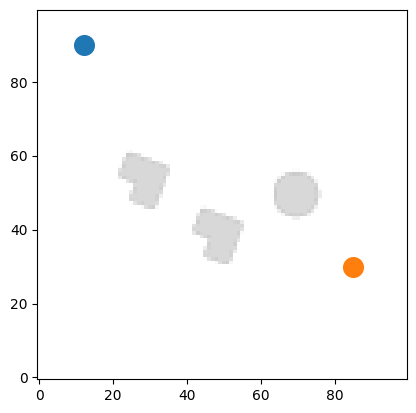

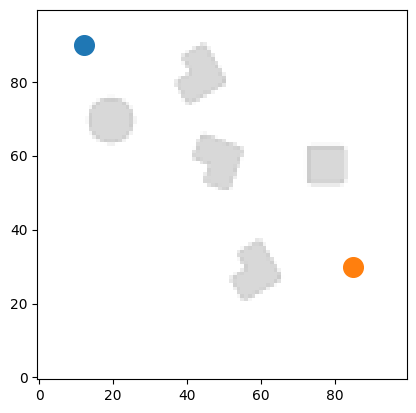

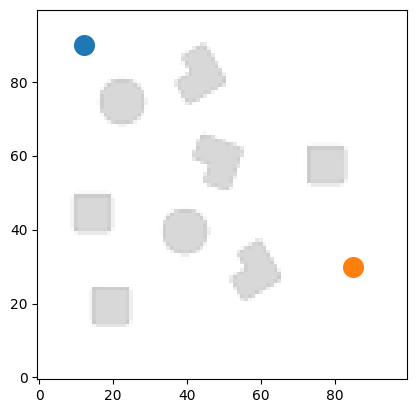

In [8]:
#@title Criando Cenários Teste

cenario_1 = Scenario(grid_size=(100, 100), min_distance=10)
cenario_1.set_start(10, 50)
cenario_1.set_end(90, 50)

cenario_2 = Scenario(grid_size=(100, 100), min_distance=10)
cenario_2.set_start(12, 90)
cenario_2.set_end(85, 30)

cenario_3 = Scenario(grid_size=(100, 100), min_distance=10)
cenario_3.set_start(12, 90)
cenario_3.set_end(85, 30)

L = ObstacleFactory.create_L(size=5, rotation=160)
L2 = ObstacleFactory.create_L(size=5, rotation=120)
esfera = ObstacleFactory.create_circle(radius=5)
quadrado = ObstacleFactory.create_square(side_length=8)
quadrado2 = ObstacleFactory.create_square(side_length=3)

cenario_1.add_obstacle(L, position=(30, 55))
cenario_1.add_obstacle(L, position=(50, 40))
cenario_1.add_obstacle(esfera, position=(70, 50))

cenario_2.add_obstacle(L, position=(50, 60))
cenario_2.add_obstacle(L2, position=(60, 30))
cenario_2.add_obstacle(quadrado, position=(78, 58))
cenario_2.add_obstacle(esfera, position=(20, 70))
cenario_2.add_obstacle(L2, position=(45, 83))

cenario_3.add_obstacle(quadrado, position=(20, 20))
cenario_3.add_obstacle(esfera, position=(40, 40))
cenario_3.add_obstacle(quadrado, position=(15, 45))
cenario_3.add_obstacle(L, position=(50, 60))
cenario_3.add_obstacle(L2, position=(60, 30))
cenario_3.add_obstacle(quadrado, position=(78, 58))
cenario_3.add_obstacle(esfera, position=(23, 75))
cenario_3.add_obstacle(L2, position=(45, 83))
#cenario_3.add_obstacle(quadrado2, position=(20, 80))

cenarios_des = [cenario_1, cenario_2, cenario_3]
cenarios_des_sem_margem_img = [c.save_scenario_image(dpi=13, figsize=(10, 10)) for c in cenarios_des]
cenarios_des_com_margem_img = [c.save_scenario_image(dpi=13, figsize=(10, 10), margem_seguranca=1) for c in cenarios_des]

for c in cenarios_des_com_margem_img:
  plt.imshow(c)
  plt.scatter(cenario_3.start.get_point().x, cenario_3.start.get_point().y, s=200)
  plt.scatter(cenario_3.end.get_point().x, cenario_3.end.get_point().y, s=200)
  plt.gca().invert_yaxis()
  plt.show()

## Algoritmo

In [9]:
#@title LocalPathSkeletonizer
class LocalPathSkeletonizer():

  @staticmethod

  def find_local_path(cenario, ponto_inicial, ponto_final, tamanho_roi, show_iteration=False, ahead=False):

    time_start = time.time()

    centro_roi = centro_roi_anterior = ponto_inicial
    distancia_centro_roi_ao_ponto_final = GeometryUtils.distancia_entre_pontos(centro_roi, ponto_final)
    distancia_limite = tamanho_roi[0] / 2
    path = Path()
    historico_limites_roi = []
    historico_esqueletos = []
    count = 0

    while distancia_centro_roi_ao_ponto_final >= distancia_limite:
      if show_iteration:
        print('=============== Iteração ', count, ' ================')
        count += 1

      limites_roi = GeometryUtils.calcula_left_top_right_bottom_roi(centro_roi, tamanho_roi)


      historico_limites_roi.append(limites_roi)

      roi = GeometryUtils.get_roi(limites_roi, cenario)

      prox_ponto = GeometryUtils.calcular_intersecao_com_limite(centro_roi, limites_roi, ponto_final)


      if not PathfindingUtils.algoritmo_bresenham_2_canais(centro_roi, prox_ponto, 1 - cenario):


        path.add_point(geometry.Point(centro_roi[0], centro_roi[1]))
        centro_roi_anterior = centro_roi
        centro_roi = prox_ponto

        if show_iteration:
          print('ROI está Livre')
          ScenarioUtils.show_iteration(cenario, ponto_inicial, ponto_final,  historico_limites_roi,  historico_esqueletos, pontos=[centro_roi_anterior, centro_roi])

          plt.show()


      else:
        if not ahead:
          path.add_point(geometry.Point(centro_roi[0], centro_roi[1]))
        roi_skeleton_image = ImageUtils.esqueletiza_imagem_skimage(roi, metodo='skeletonize')
        skeleton = Skeleton(roi_skeleton_image, limites_roi, cenario)

        historico_esqueletos.append(skeleton.get_skeleton())

        if centro_roi_anterior != centro_roi:
          #extremidade_otima = skeleton.determinar_extremidade_otima(centro_roi_anterior, centro_roi)
          extremidade_otima = skeleton.determinar_extremidade_otima_sem_colisao(centro_roi_anterior, centro_roi)


        else:
          for i in skeleton.get_extremidades():
            menor_distancia = np.inf
            distancia = GeometryUtils.distancia_entre_pontos(i, ponto_final)
            if distancia < menor_distancia:
              menor_distancia = distancia
              extremidade_otima = tuple(i)

        if show_iteration:
          print('ROI não está Livre')

          ScenarioUtils.show_iteration(cenario, ponto_inicial, ponto_final, historico_limites_roi,
                                      historico_esqueletos, pontos=[centro_roi,  extremidade_otima])

          plt.show()
        centro_roi = extremidade_otima

        if not path.contains(geometry.Point(ponto_inicial[0], ponto_inicial[1])):
          path.add_point(geometry.Point(ponto_inicial[0], ponto_inicial[1]))

        if ahead:
          path.add_point(geometry.Point(centro_roi[0], centro_roi[1]))

      distancia_centro_roi_ao_ponto_final = GeometryUtils.distancia_entre_pontos(prox_ponto, ponto_final)
      time_end = time.time()

      # if time_end - time_start > 45:
      #   return None
      # if count > 200:
      #       return None
    if not path.contains(geometry.Point(ponto_final[0], ponto_final[1])):
      path.add_point(geometry.Point(ponto_final[0], ponto_final[1]))


    return path



=============== Iteração  0  ================
ROI está Livre


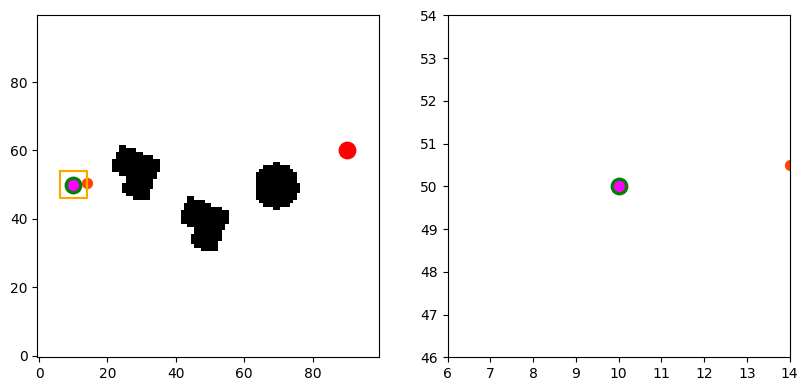

=============== Iteração  1  ================
ROI está Livre


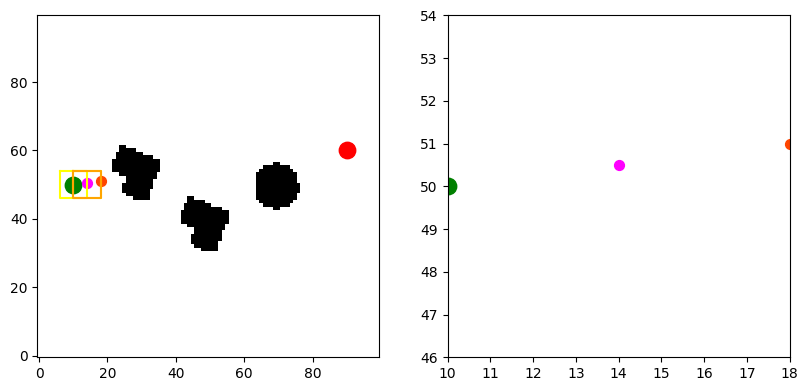

=============== Iteração  2  ================
ROI está Livre


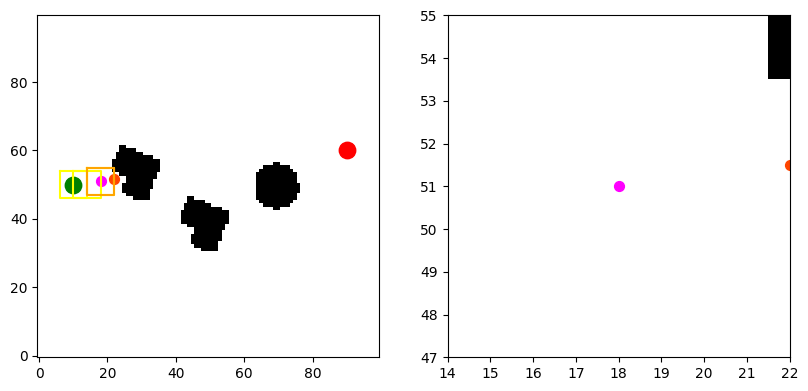

=============== Iteração  3  ================
ROI está Livre


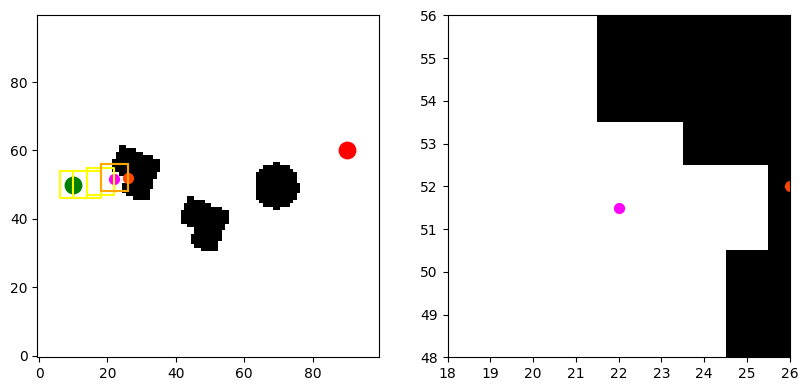

=============== Iteração  4  ================
ROI não está Livre


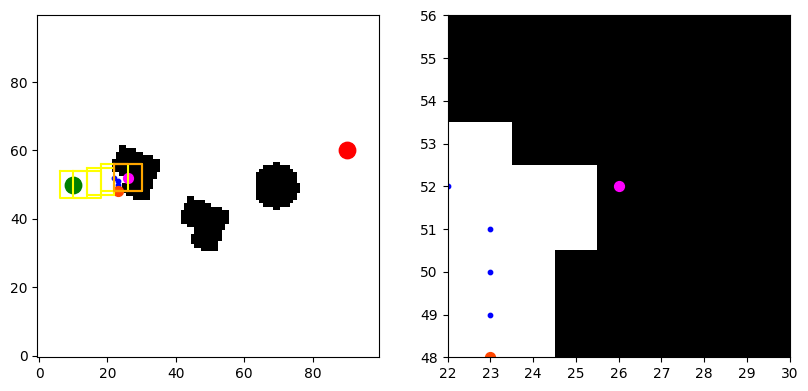

=============== Iteração  5  ================
ROI não está Livre


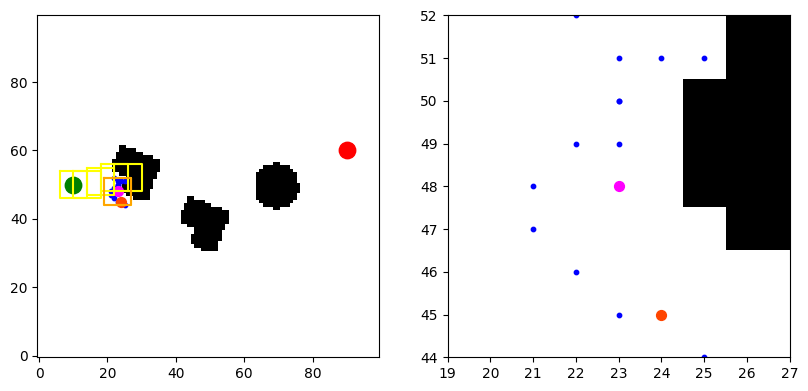

=============== Iteração  6  ================
ROI está Livre


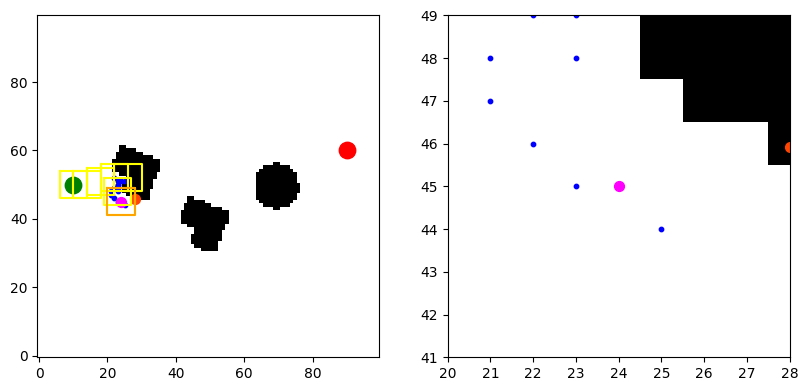

=============== Iteração  7  ================
ROI não está Livre


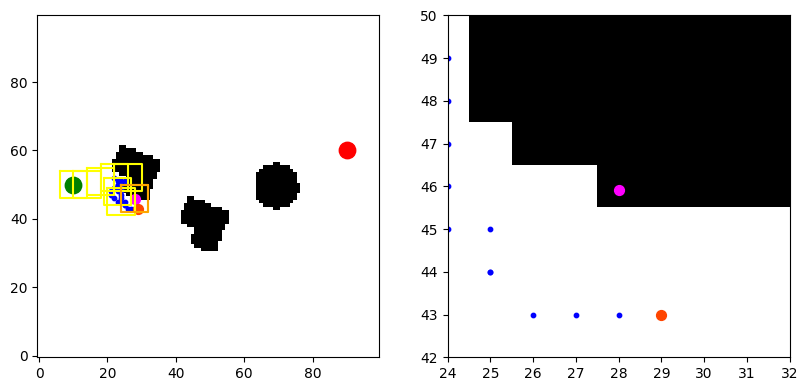

=============== Iteração  8  ================
ROI está Livre


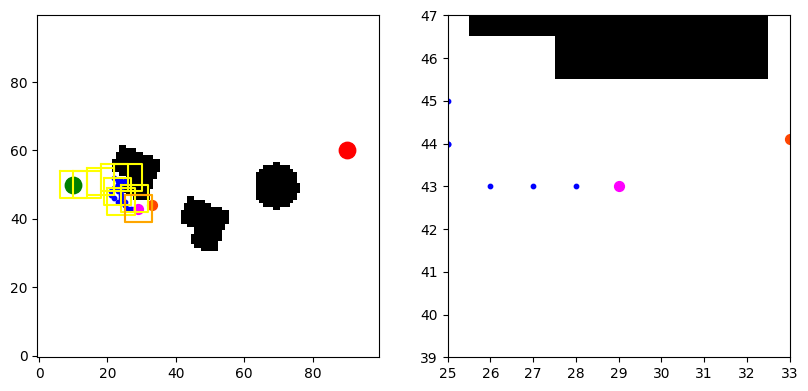

=============== Iteração  9  ================
ROI está Livre


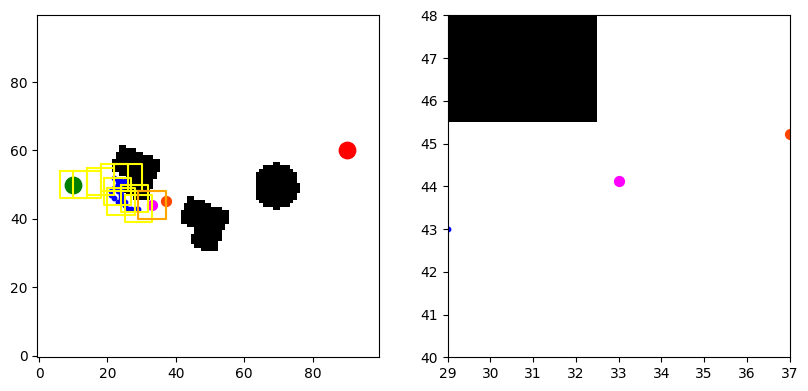

=============== Iteração  10  ================
ROI está Livre


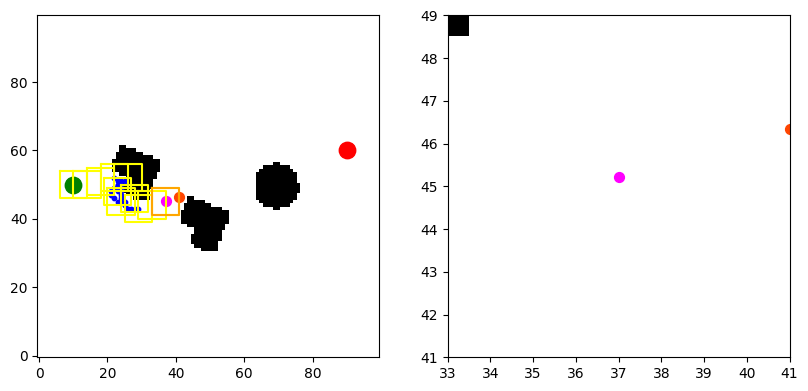

=============== Iteração  11  ================
ROI está Livre


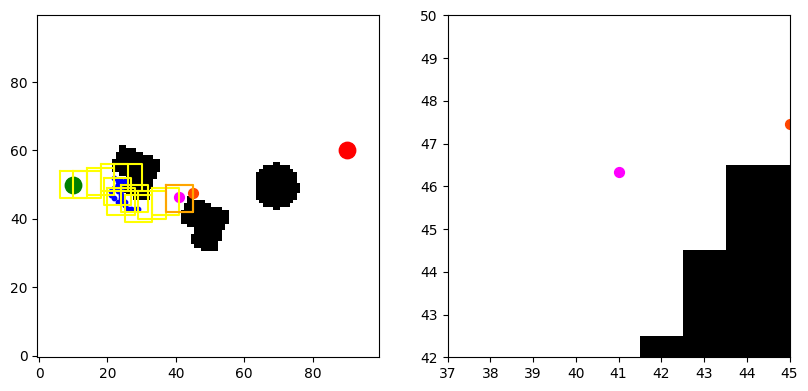

=============== Iteração  12  ================
ROI está Livre


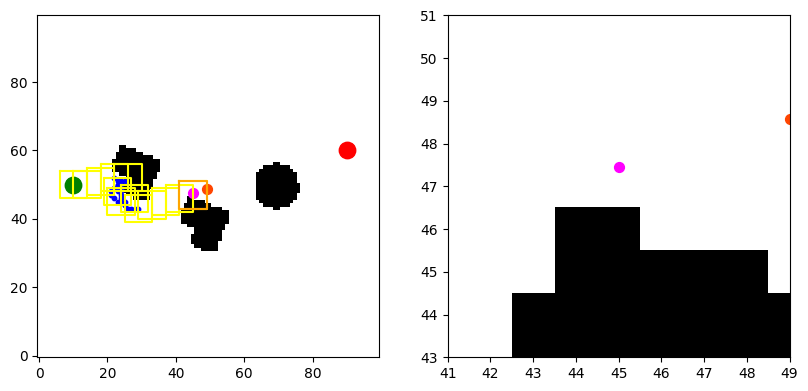

=============== Iteração  13  ================
ROI está Livre


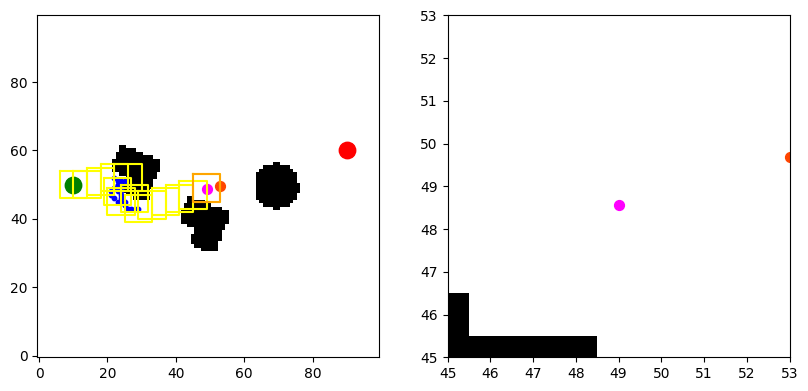

=============== Iteração  14  ================
ROI está Livre


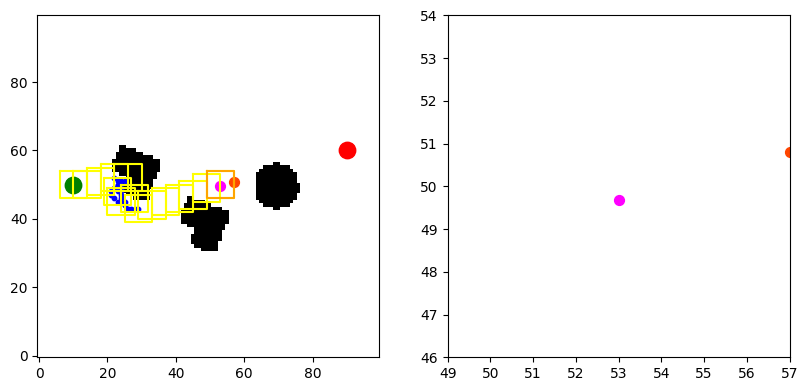

=============== Iteração  15  ================
ROI está Livre


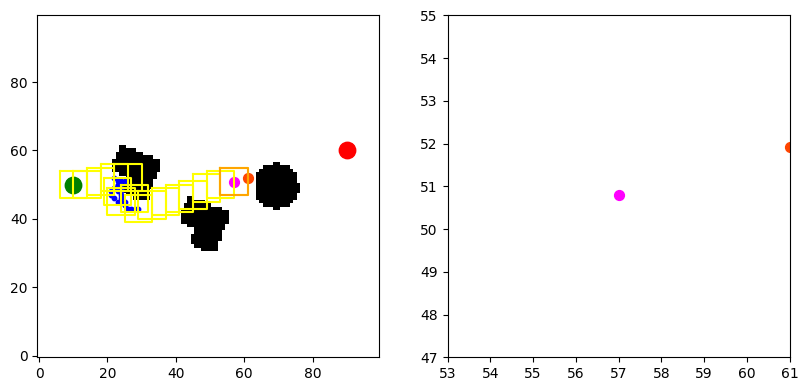

=============== Iteração  16  ================
ROI não está Livre


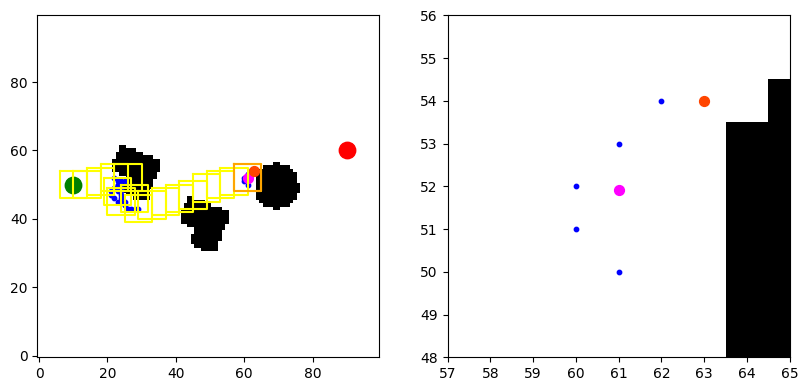

=============== Iteração  17  ================
ROI não está Livre


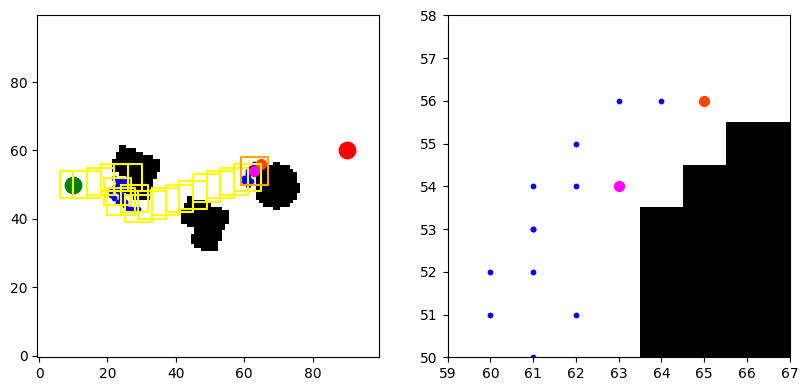

=============== Iteração  18  ================
ROI está Livre


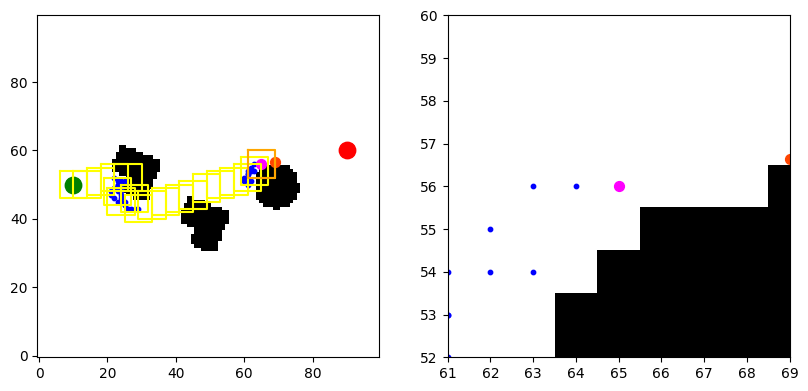

=============== Iteração  19  ================
ROI está Livre


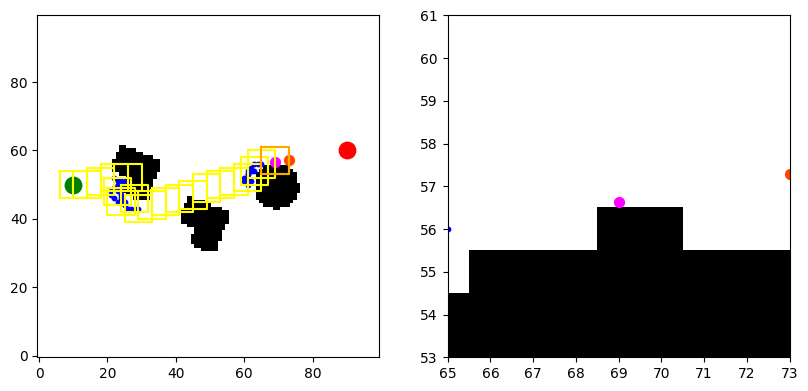

=============== Iteração  20  ================
ROI está Livre


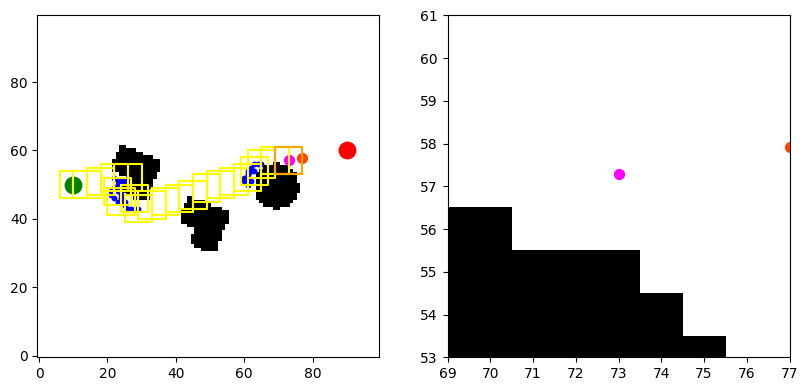

=============== Iteração  21  ================
ROI está Livre


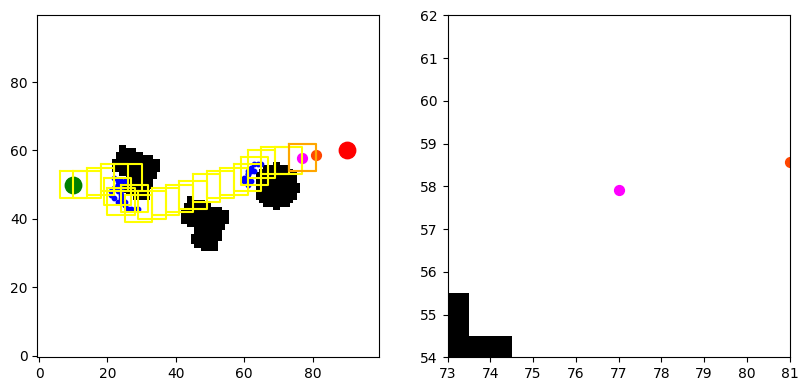

=============== Iteração  22  ================
ROI está Livre


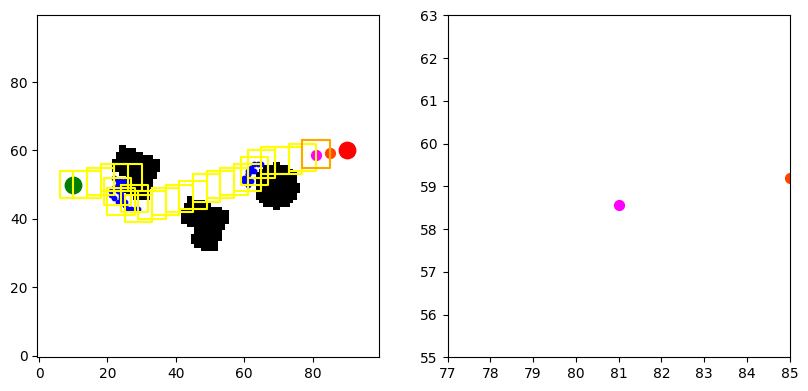

=============== Iteração  23  ================
ROI está Livre


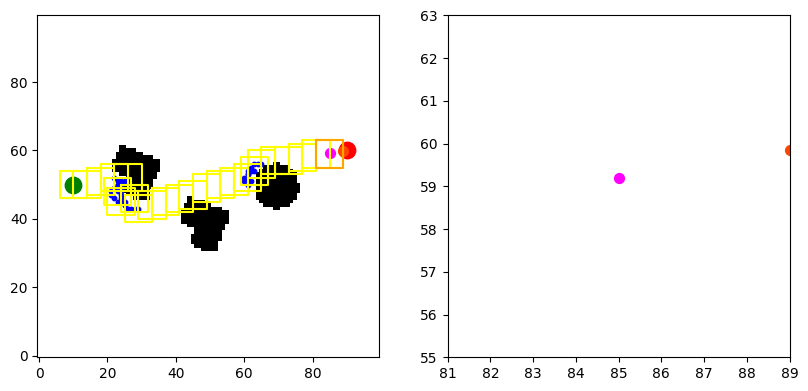

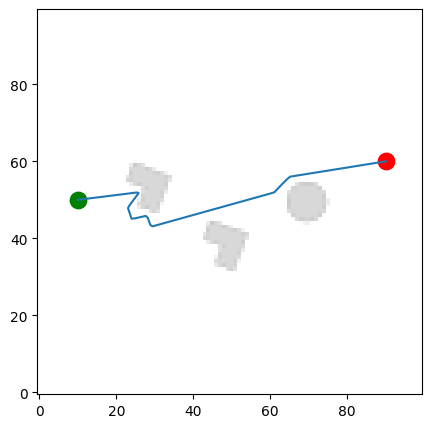

In [16]:
cen = 0

ponto_inicial = (10, 50)
ponto_final = (90, 60)


tamanho_roi = (8, 8)
cenario_binarizado = ImageUtils.binarizacao_imagem_skimage(cenarios_des_com_margem_img[cen])

path = LocalPathSkeletonizer.find_local_path(cenario_binarizado, ponto_inicial, ponto_final, tamanho_roi=tamanho_roi, show_iteration=True)


path_x, path_y = path.get_path_xy()
path_x, path_y = zip(*[(p.x, p.y) for p in PathAnalyzer.reamostrar_caminho(path.get_path())])
plt.figure(figsize=(5, 5))
plt.imshow(cenarios_des_sem_margem_img[cen], cmap='gray')
plt.gca().invert_yaxis()
plt.scatter(ponto_inicial[0], ponto_inicial[1], color='green', s=140)
plt.scatter(ponto_final[0], ponto_final[1], color='red', s=140)
plt.plot(path_x, path_y)
plt.show()